# Assessment of Integrated HV-LV OE Calculations to Orchestrate DERs 
# OE Algorithm 1: Ideal

## 1. Introduction
This repository is part of the project [Accelerating the Implementation of Operating Envelopes Across Australia](https://electrical.eng.unimelb.edu.au/power-energy/projects/accelerating-the-implementation-of-operating-envelopes-across-australia) funded by CSIRO. This project provided key metrics, recommendations, and guidance for distribution companies (known as Distribution Network Service Providers [DNSPs] in Australia) and AEMO (the Australian system operator) to assist them in improving and, hence, accelerating the use of Operating Envelopes (OEs) across Australia.

> <span style="color:purple">**What are Operating Envelopes (OEs)?** OEs are time-varying export or import limits calculated in real time or in advance at the connection point of the customer to ensure the integrity of the distribution network (i.e., customer voltages within limits and no asset congestion). The OEs are calculated only for customers with flexible connection agreements (called here *flexible customers*). Customers with conventional connection agreements (called here *fixed customers*) do not require OEs.</span>

**This interactive notebook demonstrates the process to implement the *Ideal OE Algorithm with Integrated HV-LV Calculations*** produced by The University of Melbourne. This demonstration is useful for different stakeholders (e.g., DNSPs, AEMO, CSIRO, regulators, consultancy companies, technology providers) as it can help them familiarise with the corresponding algorithm and the required inputs as well as the pros and cons.

> <span style="color:purple">The **Ideal OE with Integrated HV-LV Calculations** is the most advanced and, hence, the most accurate OE approach as it uses power flows to carry out calculations. However, it needs a full HV-LV electrical network model, full monitoring of customers, and monitoring at the HV head of feeders, which make its implementation complex and likely impractical. But if the electrical model and monitoring data are all correct, this approach can produce OEs for flexible customers that can ensure the adequate operation of the HV-LV network within technical limits (i.e., voltage and thermal). Therefore, this operating envelope is used as a benchmark for the simpler ones studied in the project.</span>
> - Monitoring: At HV head of feeders (P, Q, and V, all per phase), at all customers (net demand P and Q).
> - Electrical models: Full three-phase integrated HV-LV electrical network model.

## 2. Algorithm Overview
The **Ideal OE with Integrated HV-LV Calculations** uses a perfect electrical network model of a given HV-LV network together with the time-varying input data from the network and customers to carry out heuristic algorithms. These algorithms consist of a series of power flows calculations with a decreasing OE value – starting from a predefined maximum OE, which is usually limited by the customer connection agreement – applied to all flexible customers. This OE value is decreased until the HV and LV networks do not present any thermal or voltage problems, at this point the OE value was found. The proportional allocation technique is used in this project, as presented below. Note that for calculations in advance (e.g., hours ahead), forecasting capabilities are also needed (however, here, perfect forecasting is used for simplicity).

For a given point in time (e.g., at 12:00PM), the high-level steps of the algorithm are as follows:
1. **Set up the electrical network for power flow simulations for OE exports (or OE imports)**. This is done by using the integrated HV-LV electrical network model together with the voltage at the HV head of feeder and the net demand from fixed customers (P, Q) and flexible customers (Q). Also set the net active power of each flexible customer to the maximum possible value for OE export (or OE import). Since it is a proportional allocation, for OE exports, the maximum possible OE value is the installed capacity of DERs located in each flexible customer. In case the DER installed capacity is higher than the customer connection agreement (e.g., 10kW maximum export per phase), the value stablished by the customer connection agreement is used instead. For OE imports, the fuse of the flexible customer (e.g., 60A fuse for a single-phase customer, giving a total power of 14kW) is used as the maximum possible OE value.
2. **Run the power flow**.
3. **Check for voltage and thermal issues in the whole network for the OE exports (or OE imports)**. If any network limit is breached (voltage or thermal), proportionally reduce the net active power of all flexible customers by a pre-defined value (e.g., 1% of the maximum possible OE), then go back to step 2. Otherwise, the current net active power of flexible customers correspond to the OE exports (or OE imports), thus proceed to step 4.
4. **Move to the next time step (e.g., 12:05PM) and restart the process from 1**.

<span style="color:red">**<u>Note 1</u>.</span>** The OE exports and OE imports are calculated separately. When calculating exports, all flexible customers are considered to export. When calculating imports, all flexible customers are considered to import. This ensures the asset integrity even if all flexible customers operate at their maximum allocated OE capacity (worst case scenario).

<span style="color:red">**<u>Note 2</u>.</span>** For OE calculations in real-time no forecast is needed, real-time measurements from the network and customers should be used instead.

<span style="color:red">**<u>Note 3</u>.</span>** The OE values are calculated for the active power only. The reactive power of PV systems are considered to be zero all the time.

## 3. Inputs and Outputs for the OE Calculation Algorithm
### Time-Varying Inputs
- Forecasted voltage magnitude at the HV head of feeder.
- Forecasted net demand (P, Q) of all fixed customer.
- Forecasted net demand (Q) of all flexible customers.

### Static Inputs
- Accurate full electrical model of the integrated HV-LV network (i.e., topology, phase connection of assets and customers, and impedance of conductors).
- Rated capacity of the primary substation and distribution transformer, as well as of HV and LV lines.

### Outputs
- The OE values for exports or imports. 

## Test Case Study
A real 22kV HV feeder from Victoria, Australia, with 79 distribution transformers is used to demonstrate the OE algorithm, as shown in Figure 1. This integrated HV-LV network has the following characteristics:
- One 3-phase HV feeder (22kV)
- 79 distribution transformers (22kV/0.433kV)
- 3,374 single-phase-connected residential customers (distributed along 70 distribution transformers)
- 9 C&I customers (on the other 9 distribution transformers)

The following scenario is considered:
- 1,856 residential customers (~55% of total) are considered fixed customers without PV systems.
- 1,012 residential customers (~30% of total) are considered fixed customers with PV systems.
- 506 residential customers (~15% of total) are flexible customers.
- Fixed customers with PV systems have installed capacity ranging from 1.25kVA to 11.75kVA (based on Australian stats from 2020-2022). Their PV systems also have the combined Volt-Watt and Volt-Var functions enabled (as per Australian Standards).
- Flexible customers have PV systems with installed capacity ranging from 1.25kVA to 11.75kVA (based on Australian stats from 2022-2023).
- Customer demands and PV irradiance are from the summer of 2014 in Victoria, Australia.
- The simulation is carried out for three days.

<img style="float: middle;" src="HV_feeder.SVG" width="100%">

**<center>Figure 1. 22kV HV feeder with 79 distribution transformers</center>**

## 5. Interactive Code
<span style="color:red">**<u>Note</u>.</span>** This interactive notebook is designed to facilitate the learning/teaching of the content. Therefore, the definitions of functions are not made at the beginning of the notebook as it is usually done when just coding.
### 5.1. Initialisation of Libraries and OpenDSS 

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import copy
import dss

### 5.2. Get Directory and Initialise OpenDSS

In [2]:
# Get directory location
mydir = os.getcwd()

# Initialise the OpenDSS (this allows to run the power flows later)
dss_engine = dss.DSS
dss_text = dss_engine.Text                                                      
dss_circuit = dss_engine.ActiveCircuit                                            
dss_solution = dss_engine.ActiveCircuit.Solution                                      
control_queue = dss_engine.ActiveCircuit.CtrlQueue                                          
dss_engine.AllowForms = 0

### 5.3. Load/Prepare Necessary Inputs
Load the necessary inputs to calculate the Ideal OE.

In [3]:
# Define time resolution of the data
time_resolution = 5 # in minutes

# Define number of time steps in the day (24h) for the corresponding time resolution
num_time_steps = 288

# Set number of distribution transformers
num_distr_tx = 79

# Set number of days to be simulated
num_days = 3

# Name of all flexible customers in the integrated HV-LV network
all_flex_cust_names = np.load(mydir + '/simulation_files/scenario/scenario2_all_flex_cust_names.npy', allow_pickle=True) 

# Name of all flexible customers in the integrated HV-LV networks separated by LV network
all_flex_cust_names_per_lv = np.load(mydir + '/simulation_files/scenario/scenario2_flex_cust_names.npy', allow_pickle=True) 

# Capacity of each distribution transformer of the integrated HV-LV networks separated by LV network
all_lvtx_capacity = np.load(mydir + '/simulation_files/lvtx_capacity.npy')   

# DER size of all flexible customers in the integrated HV-LV networks separated by LV network
all_flex_cust_der_size = np.load(mydir + '/simulation_files/scenario/scenario2_lv_flex_cust_der_size.npy', allow_pickle=True)

# Load the integrated HV-LV network (includes transformer, feeders, loads, PV systems, PV inverter settings, demands, PV generation)
dss_text.Command = 'Clear'
dss_text.Command = 'Compile ' + mydir + '/simulation_files/network/master.txt' 
dss_text.Command = 'Set VoltageBases=[66.0, 22.0, 0.400, 0.2309]'
dss_text.Command = 'calcv'
dss_text.Command = 'Set ControlMode=static'
dss_text.Command = 'Reset'                                                     
dss_text.Command = 'Set Mode=daily number=1 stepsize='+str(time_resolution)+'m' 

# Extract names of all lines from OpenDSS
line_names = dss_circuit.Lines.AllNames

# Extract names of all loads from the OpenDSS
load_names = dss_circuit.Loads.AllNames

# Count number of LV lines (all LV networks together) and number of HV lines
num_lv_lines = 0
num_hv_lines = 0
for iln in line_names:
    if len(iln.split('_')) == 3:
        num_hv_lines += 1
    else:
        num_lv_lines += 1

# Initialise arrays to save the OE values from all customers in the integrated HV-LV distribution network for each time step
ideal_oe_prop_exp_values = np.zeros((num_distr_tx, num_time_steps*num_days), object) # for exports
ideal_oe_prop_imp_values = np.zeros((num_distr_tx, num_time_steps*num_days), object) # for imports


### 5.3. Create Functions for the Ideal OE Algorithms
#### OEs for Exports with Proportional Allocation

In [4]:
def ideal_oe_prop_exp_algorithm(
    all_flex_cust_names,
    all_flex_cust_names_per_lv,
    all_flex_cust_der_size,
    all_lvtx_capacity,
    dss_engine
):
    """
    Function to calculate the Ideal OE proportional allocation for exports in each time step.
    This is used in every time step of the simulation.  
    :param all_flex_cust_names: name of all flexible customers in the integrated HV-LV network
    :param all_flex_cust_names_per_lv: name of all flexible customers in the integrated HV-LV networks separated by LV network
    :param all_flex_cust_der_size: DER size of all flexible customers in the integrated HV-LV network
    :param all_lvtx_capacity: capacity of each distribution transformer of the integrated HV-LV networks separated by LV network
    :param dss_engine: the OpenDSS engine
    :return final_alloc_exp_p: the calculated ideal OE export value for proportional allocation
    """
    
    # Initialise local OpenDSS variables
    dss_circuit = dss_engine.ActiveCircuit                                            
    dss_solution = dss_engine.ActiveCircuit.Solution                                      
    dss_engine.AllowForms = 0
    
    # Load LV network data from the OpenDSS model
    load_names = dss_circuit.Loads.AllNames # list of loads
    line_names = dss_circuit.Lines.AllNames # list of lines
    transf_names = dss_circuit.Transformers.AllNames # list of transformers
    
    # Count number of LV lines (all LV networks together) and number of HV lines
    num_lv_lines = 0
    num_hv_lines = 0
    for iln in line_names:
        if len(iln.split('_')) == 3:
            num_hv_lines += 1
        else:
            num_lv_lines += 1
    
    # Initialise local variables
    max_voltage = 253  # statutory voltage limit to check against (+10% from the nominal line-to-neutral voltage of 230V)
    oe_step_size = 0.01 # Pre-defined reduction for the OE values (in percentage)
    oe_percent = [[]] * len(all_flex_cust_der_size)
    for itx in range(len(all_flex_cust_der_size)):
        oe_percent[itx] = 1 # Each flexible customer starts with an OE with the size of the corresponding DER size
      
    # Allocate the maximum possible OE exports at the connection point of each flexible customer 
    # Since we assume the DNSP has the knowledge of flexible customers' DER sizes, it is used to make a proportional OE allocation that will not pass the DER size
    alloc_exp_p_temp = [[]] * len(all_flex_cust_der_size)
    for itx in range(len(all_flex_cust_der_size)):
        if any(all_flex_cust_der_size[itx]):
            for ild in range(len(all_flex_cust_der_size[itx])):
                if ild == 0:
                    alloc_exp_p_temp[itx] = np.zeros(len(all_flex_cust_der_size[itx]), float)
                alloc_exp_p_temp[itx][ild] = all_flex_cust_der_size[itx][ild]
                if alloc_exp_p_temp[itx][ild] > 10:
                    alloc_exp_p_temp[itx][ild] = 10 # 10kVA is the maximum allowed OE value for exports per phase
            
    # Deactivate PV systems in flexible customers in OpenDSS (OE export is going to be modelled as negative load next)
    for ild in all_flex_cust_names:
        dss_circuit.SetActiveElement('pvsystem.pv_' + str(ild)) # select a flexible customer
        dss_circuit.ActiveElement.Properties('enabled').Val = 'false' # turn off the PV system in OpenDSS

    # Iteratively run power flow calculations with reducing OE export values until the point that technical issue is found in the integrated HV-LV network.
    flag = 0 # Overall flag to indicate if the integrated HV-LV network have technical issues (0 = problems; 1 = no problems)
    while flag == 0:
        
        # Implement the allocated OE value to each flexible customer
        for itx in range(len(all_flex_cust_names_per_lv)):
            if any(all_flex_cust_names_per_lv[itx]):
                for ild in range(len(all_flex_cust_names_per_lv[itx])):
                    dss_circuit.SetActiveElement('load.' + all_flex_cust_names_per_lv[itx][ild]) # select a flexible customer
                    temp = dss_circuit.ActiveElement.Powers[1] # save the current reactive power of the flexible customer
                    dss_circuit.ActiveElement.Properties('status').Val = 'fixed' # fix the load status to run with the set OE value instead of profile
                    dss_circuit.ActiveElement.Properties('kw').Val = str(-1 * alloc_exp_p_temp[itx][ild] * oe_percent[itx]) # set the kW to the allocated OE export value
                    dss_circuit.ActiveElement.Properties('kvar').Val = str(temp) # set the kvar to be the same as before
        
        dss_solution.SolveSnap() # solve the power flow in OpenDSS without changing the time step


        
        # Verify thermal issues for LV lines of each LV network in the integrated HV-LV network
        flag_thermal_every_lv_line = [[]] * num_distr_tx # create flag to indicate which LV line has thermal problems (0 = problems; 1 = no problems)
        for itx in range(num_distr_tx):
            flag_thermal_every_lv_line[itx] = []
            if (itx == 5 or itx == 6 or itx == 9 or itx == 10 or itx == 12 or itx == 15 or itx == 18 
                or itx == 37 or itx == 48): # these are commercial customers (they are never flexible customers in the case study), so no thermal issues
                flag_thermal_every_lv_line[itx] = 1
        
        for iln in line_names: # loop to check every line for thermal problems
            line_util_temp = []
            if (iln[8:10] == '5_' or iln[8:10] == '6_' or iln[8:10] == '9_' or iln[8:10] == '10' or iln[8:10] == '12' 
                or iln[8:10] == '15' or iln[8:10] == '18' or iln[8:10] == '37' or iln[8:10] == '48'): # these are commercial customers (they are never flexible customers in the case study), so no thermal issues
                pass
            elif len(iln.split('_')) > 3: # filtering LV network lines via their names
                dss_circuit.SetActiveElement('line.' + iln) # Activate a given line in OpenDSS
                Ia_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[0], dss_circuit.ActiveCktElement.CurrentsMagAng[6]) # extract current in phase A
                Ib_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[2], dss_circuit.ActiveCktElement.CurrentsMagAng[8]) # extract current in phase B
                Ic_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[4], dss_circuit.ActiveCktElement.CurrentsMagAng[10]) # extract current in phase C
                I_phase_capacity = dss_circuit.Lines.NormAmps # extract rated capacity of the line

                line_util_temp.append(100 * (Ia_temp / I_phase_capacity)) # calculate the line utilisation per phase and add to a list
                line_util_temp.append(100 * (Ib_temp / I_phase_capacity)) # calculate the line utilisation per phase and add to a list
                line_util_temp.append(100 * (Ic_temp / I_phase_capacity)) # calculate the line utilisation per phase and add to a list
        
                # check if the line current is above the rated capacity of the corresponding line
                if any(ph > 100 for ph in line_util_temp):
                    # update flag to indicate where there is a thermal problem (0 = problems)
                    flag_thermal_every_lv_line[int(iln.split('_')[2].strip('lv'))].append(0) 
                else:
                    # update flag to indicate where there is a thermal problem (1 = no problems) 
                    flag_thermal_every_lv_line[int(iln.split('_')[2].strip('lv'))].append(1)

        # check if any thermal issue was found in each LV network        
        flag_thermal_lv_temp = np.zeros(num_distr_tx, dtype=np.float16)
        for itx in range(num_distr_tx):
            if np.array(flag_thermal_every_lv_line[itx]).all():
                # update a flag if no thermal problem was found in the given LV network (1 = no problems)
                flag_thermal_lv_temp[itx] = 1
            else:
                # update a flag if any thermal problem was found in the given LV network (0 = problems)
                flag_thermal_lv_temp[itx] = 0
        
        # Update the overall flag for thermal issues in LV lines (0 = problems; 1 = no problems)
        if flag_thermal_lv_temp.all():
            # if no thermal problems
            flag_thermal_lv_lines = 1
        else:
            # if any thermal problem
            flag_thermal_lv_lines = 0



        # Verify thermal issues for each distribution transformer of the integrated HV-LV network
        lv_tx_util = np.zeros(num_distr_tx, dtype=np.float16)
        flag_thermal_every_lv_tx = [[]] * num_distr_tx # flag to indicate which distribution transformer has thermal problems (0 = problems; 1 = no problems)
        for itx in transf_names:
            if len(itx.split('_')) > 3: # filter based on transformer name to assess only distirbution transformers
                lv_tx_util_temp = []
                dss_circuit.SetActiveElement('transformer.' + itx) # set the transformer active in OpenDSS
                number_phases = dss_circuit.ActiveElement.NumPhases # extract from OpenDSS the number of phases of the transformer
                if number_phases == 3: # Extract power from three-phase transformers
                    P2_LVTx_temp = dss_circuit.ActiveElement.Powers[8] + dss_circuit.ActiveElement.Powers[10] + dss_circuit.ActiveElement.Powers[12] # three-phase active power at the secondary of the transformer 
                    Q2_LVTx_temp = dss_circuit.ActiveElement.Powers[9] + dss_circuit.ActiveElement.Powers[11] + dss_circuit.ActiveElement.Powers[13] # three-phase reactive power at the secondary of the transformer
                    S2_LVTx_temp = np.sqrt(P2_LVTx_temp**2 + Q2_LVTx_temp**2) # three-phase apparent power at the secondary of the transformer
                elif number_phases == 1: # Extract power from single-phase transformers
                    P2_LVTx_temp = dss_circuit.ActiveElement.Powers[4] # single-phase active power at the secondary of the transformer
                    Q2_LVTx_temp = dss_circuit.ActiveElement.Powers[5] # single-phase reactive power at the secondary of the transformer
                    S2_LVTx_temp = np.sqrt(P2_LVTx_temp**2 + Q2_LVTx_temp**2) # single-phase apparent power at the secondary of the transformer

                # calculate the utilisation of the distribution transformer    
                lv_tx_util_temp = 100 * (S2_LVTx_temp / all_lvtx_capacity[int(itx.split('_')[2].strip('lv'))])
                lv_tx_util[int(itx.split('_')[2].strip('lv'))] = lv_tx_util_temp 
                        
                # check if the distribution transformer power flow is above its rated power
                if lv_tx_util[int(itx.split('_')[2].strip('lv'))] > 100:
                    # flag to indicate where there is a thermal problem (0 = problems)
                    flag_thermal_every_lv_tx[int(itx.split('_')[2].strip('lv'))] = 0
                else:
                    # flag to indicate where there is a thermal problem (1 = no problems) 
                    flag_thermal_every_lv_tx[int(itx.split('_')[2].strip('lv'))] = 1

        # Update the overall flag for thermal issues in distribution transformers (0 = problems; 1 = no problems)           
        if np.array(flag_thermal_every_lv_tx, dtype=object).all():
            # if no thermal problem
            flag_thermal_lv_tx = 1 
        else:
            # if any thermal problem
            flag_thermal_lv_tx = 0  
        
        
       
        # verify thermal issues for HV lines
        hv_lines_util = np.zeros((num_hv_lines, 3), dtype=np.float16)
        count = 0
        flag_thermal_every_hv_line = [[]] * num_hv_lines # flag to indicate which HV line has thermal problems (0 = problems; 1 = no problems)
        for iln in line_names:
            line_util_temp = []
            if len(iln.split('_')) == 3: # filter based on line name to assess only HV lines
                dss_circuit.SetActiveElement('line.' + iln) # set the line active in OpenDSS
                Ia_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[0], dss_circuit.ActiveCktElement.CurrentsMagAng[6]) # extract current in phase A from OpenDSS
                Ib_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[2], dss_circuit.ActiveCktElement.CurrentsMagAng[8]) # extract current in phase B from OpenDSS
                Ic_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[4], dss_circuit.ActiveCktElement.CurrentsMagAng[10]) # extract current in phase C from OpenDSS
                I_phase_capacity = dss_circuit.Lines.NormAmps # Extract rated capacity of the line from OpenDSS

                # calculate the line utilisation in each phase
                line_util_temp.append(100 * (Ia_temp / I_phase_capacity))
                line_util_temp.append(100 * (Ib_temp / I_phase_capacity))
                line_util_temp.append(100 * (Ic_temp / I_phase_capacity))
                hv_lines_util[count, :] = line_util_temp 
        
                # check if the line current is above the rated current of the corresponding line
                if any(ph > 100 for ph in line_util_temp):
                    # flag to indicate when there is a thermal problem (0 = problems)
                    flag_thermal_every_hv_line[count] = 0
                else:
                    # flag to indicate when there is a thermal problem (1 = no problems) 
                    flag_thermal_every_hv_line[count] = 1 
                
                count += 1
        
        # Update the overall flag for thermal issues in HV lines (0 = problems; 1 = no problems)         
        if np.array(flag_thermal_every_hv_line).all():
            # if no thermal problems
            flag_thermal_hv_lines = 1
        else:    
            # if any thermal problem
            flag_thermal_hv_lines = 0
        
        

        # verify voltages at all customers
        volt_all_cust = []
        
        # collect the voltage from all customers
        flag_voltages_every_cust = [[]] * num_distr_tx # flag to indicate which customer has voltage problems (0 = problems; 1 = no problems)
        for itx in range(num_distr_tx):
            flag_voltages_every_cust[itx] = []

        for ild in load_names:
            dss_circuit.SetActiveElement('load.' + str(ild)) # Set the customer active in OpenDSS
            volt_cust_temp = dss_circuit.ActiveElement.VoltagesMagAng[0] # Extract the customer voltage magnitude from OpenDSS
            volt_all_cust.append(volt_cust_temp) # save the voltage magnitude the customer
            
            # verify if the voltage of any of the customers is above the maximum statutory limit (253V)
            if any(all_flex_cust_names_per_lv[int(ild.split('_')[2].strip('lv'))]): # check if there is any flexible customer at a given LV network
                if volt_cust_temp > max_voltage:
                    flag_voltages_every_cust[int(ild.split('_')[2].strip('lv'))].append(0) # flag to indicate when there is a voltage problem (0 = problems)
                else:
                    flag_voltages_every_cust[int(ild.split('_')[2].strip('lv'))].append(1) # flag to indicate when there is a voltage problem (1 = no problems)
            else:
                flag_voltages_every_cust[int(ild.split('_')[2].strip('lv'))].append(1) # flag to indicate when there is a voltage problem (1 = no problems)
                
        # Update the overall flag for voltage issues customers (0 = problems; 1 = no problems) 
        if all(np.array(itx).all() for itx in flag_voltages_every_cust):
            # if no voltage problems
            flag_voltages = 1
        else:    
            # if any voltage problem
            flag_voltages = 0
 
    
 
        # Check all the flags and reduce OE value if there is any type of issue
        if flag_thermal_lv_lines == 0: # check if there is a thermal problem in any LV line of the integrated HV-LV network
            oe_percent_old = copy.deepcopy(oe_percent) # save old OE value (in percentage, so it can be proportional)
            for itx in range(num_distr_tx):
                if any(all_flex_cust_names_per_lv[itx]): # check if there is any flexible customer in the LV network
                    if np.array(flag_thermal_every_lv_line[itx]).all(): # check if there is any thermal problem in LV lines of this LV network
                        pass
                    else:
                        oe_percent[itx] -= oe_step_size # if above the limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                        if oe_percent[itx] < 0: # check if OE value is equal to zero (lowest possible value)
                            oe_percent[itx] = 0
                            if oe_percent == oe_percent_old: # check if new OE values are the same as old ones
                                flag_thermal_lv_lines = 1 # if they are the same it means that even with zero as OE value there is still an issue that cannot be solved by OEs
                
        if flag_thermal_lv_tx == 0: # check if there is a thermal problem in any distribution transformer of the integrated HV-LV network
            oe_percent_old = copy.deepcopy(oe_percent) # save old OE value (in percentage, so it can be proportional)
            for itx in range(num_distr_tx):
                if any(all_flex_cust_names_per_lv[itx]): # check if there is any flexible customer in the LV network
                    if flag_thermal_every_lv_tx[itx] == 0: # check if there is a thermal problem in the distribution transformer of this LV network
                        oe_percent[itx] -= oe_step_size # if above the limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                        if oe_percent[itx] < 0: # check if OE value is equal to zero (lowest possible value)
                            oe_percent[itx] = 0
                            if oe_percent == oe_percent_old: # check if new OE values are the same as old ones
                                flag_thermal_lv_tx = 1 # if they are the same it means that even with zero as OE value there is still an issue that cannot be solved by OEs

        if flag_thermal_hv_lines == 0: # check if there is a thermal problem in any HV line of the integrated HV-LV network
            oe_percent_old = copy.deepcopy(oe_percent) # save old OE value (in percentage, so it can be proportional)
            for itx in range(num_distr_tx):    
                if any(all_flex_cust_names_per_lv[itx]): # check if there is any flexible customer in the LV network
                    oe_percent[itx] -= oe_step_size # if above the limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                    if oe_percent[itx] < 0: # check if OE value is equal to zero (lowest possible value)
                        oe_percent[itx] = 0
                        if oe_percent == oe_percent_old: # check if new OE values are the same as old ones
                            flag_thermal_hv_lines = 1 # if they are the same it means that even with zero as OE value there is still an issue that cannot be solved by OEs
                            
        if flag_voltages == 0: # check if there is a voltage problem in any customer of the integrated HV-LV network
            oe_percent_old = copy.deepcopy(oe_percent) # save old OE value (in percentage, so it can be proportional)
            for itx in range(num_distr_tx):
                if any(all_flex_cust_names_per_lv[itx]): # check if there is any flexible customer in the LV network
                    if np.array(flag_voltages_every_cust[itx]).all(): # check if there is any voltage problem in customers of this LV network
                        pass
                    else:
                        oe_percent[itx] -= oe_step_size # if above the limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                        if oe_percent[itx] < 0: # check if OE value is equal to zero (lowest possible value)
                            oe_percent[itx] = 0
                            if oe_percent == oe_percent_old: # check if new OE values are the same as old ones
                                flag_voltages = 1 # if they are the same it means that even with zero as OE value there is still an issue that cannot be solved by OEs

        # update master flag to know if there is any technical issue (voltage or thermal) in the network
        flag = flag_thermal_lv_lines * flag_thermal_hv_lines * flag_voltages * flag_thermal_lv_tx
    
        
    
    # find final allocated OEs in kW
    final_alloc_exp_p = [[]] * len(all_flex_cust_der_size)
    for itx in range(len(all_flex_cust_der_size)):
        if any(all_flex_cust_der_size[itx]):
            for ild in range(len(all_flex_cust_der_size[itx])):
                if ild == 0:
                    final_alloc_exp_p[itx] = np.zeros(len(all_flex_cust_der_size[itx]), float)
                final_alloc_exp_p[itx][ild] = alloc_exp_p_temp[itx][ild] * oe_percent[itx]
    
    return final_alloc_exp_p # return the calculated OE values for the export for the considered time step


#### OEs for Imports with Proportional Allocation

In [5]:
def ideal_oe_prop_imp_algorithm(
    all_flex_cust_names, 
    all_flex_cust_names_per_lv,
    all_flex_cust_der_size,
    all_lvtx_capacity,
    dss_engine
):
    """
    Function to calculate the Ideal OE proportional allocation for imports in each time step.
    This is used in all time steps of the day.
    :param all_flex_cust_names: name of all flexible customers in the integrated HV-LV network
    :param all_flex_cust_names_per_lv: name of all flexible customers in the integrated HV-LV networks separated by LV network
    :param all_flex_cust_der_size: DER size of all flexible customers in the integrated HV-LV network
    :param all_lvtx_capacity: capacity of each distribution transformer of the integrated HV-LV networks separated by LV network
    :param dss_engine: the OpenDSS engine
    :return final_alloc_imp: the calculated ideal OE import value for proportional allocation
    """
    
    # initialise local OpenDSS variables
    dss_circuit = dss_engine.ActiveCircuit                                            
    dss_solution = dss_engine.ActiveCircuit.Solution                                      
    dss_engine.AllowForms = 0
    
    # load LV network data from the OpenDSS model
    load_names = dss_circuit.Loads.AllNames # list of loads
    line_names = dss_circuit.Lines.AllNames # list of lines
    transf_names = dss_circuit.Transformers.AllNames # list of transformers
    
    # count number of LV lines (all LV networks together) and number of HV lines
    num_lv_lines = 0
    num_hv_lines = 0
    for iln in line_names:
        if len(iln.split('_')) == 3:
            num_hv_lines += 1
        else:
            num_lv_lines += 1
    
    # initialise local variables
    min_voltage = 216  # statutory voltage limit to check against (-6% from the nominal line-to-neutral voltage of 230V)
    oe_step_size = 0.01 # Pre-defined reduction for the OE values (in percentage)
    oe_percent = [[]] * len(all_flex_cust_names_per_lv)
    for itx in range(len(all_flex_cust_names_per_lv)):
        oe_percent[itx] = 1 # Each flexible customer starts with an OE with the size of the corresponding DER size
      
    # Allocate the maximum possible OE imports at the connection point of each flexible customer
    # Since we assume the DNSP has the knowledge of flexible customers' DER sizes, it is used to make a proportional OE allocation that will not pass the DER size
    alloc_imp_p_temp = [[]] * len(all_flex_cust_der_size)
    for itx in range(len(all_flex_cust_der_size)):
        if any(all_flex_cust_der_size[itx]):
            for ild in range(len(all_flex_cust_der_size[itx])):
                if ild == 0:
                    alloc_imp_p_temp[itx] = np.zeros(len(all_flex_cust_der_size[itx]), float)
                alloc_imp_p_temp[itx][ild] = 14 # 14kVA is the maximum per phase allowed OE value for imports
            
    # deactivate PV systems in all flexible customers in OpenDSS
    for ild in all_flex_cust_names:
        dss_circuit.SetActiveElement('pvsystem.pv_' + str(ild)) # select a flexible customer
        dss_circuit.ActiveElement.Properties('enabled').Val = 'false' # turn off the PV system in OpenDSS

    # iteratively run power flow calculations with reducing OE import values until the point that no technical issues is found in the integrated HV-LV network.
    flag = 0 # overall flag to indicate if the integrated HV-LV network has technical issues (0 = problems; 1 = no problems)
    while flag == 0:
        
        # implement the allocated OE value to each flexible customer
        for itx in range(len(all_flex_cust_names_per_lv)):
            if any(all_flex_cust_names_per_lv[itx]):
                for ild in range(len(all_flex_cust_names_per_lv[itx])):
                    dss_circuit.SetActiveElement('load.' + all_flex_cust_names_per_lv[itx][ild]) # Set a flexible customer active in OpenDSS
                    temp = dss_circuit.ActiveElement.Powers[1] # save the current reactive power of the flexible customer
                    dss_circuit.ActiveElement.Properties('status').Val = 'fixed' # fix the load status to run with the set value instead of profile
                    dss_circuit.ActiveElement.Properties('kw').Val = str(alloc_imp_p_temp[itx][ild] * oe_percent[itx]) # set the kW to the allocated import OE value
                    dss_circuit.ActiveElement.Properties('kvar').Val = str(temp) # set the kvar to be the same as before
        
        dss_solution.SolveSnap() # solve the power flow in OpenDSS without changing the time step


        
        # verify thermal issues for LV lines of each LV network in the integrated HV-LV network 
        lv_lines_util = np.zeros((num_lv_lines, 3), dtype=np.float16)
        count = 0
        flag_thermal_every_lv_line = [[]] * num_distr_tx # create flag to indicate which LV line has thermal problems (0 = problems; 1 = no problems)
        for itx in range(num_distr_tx):
            flag_thermal_every_lv_line[itx] = []
            if (itx == 5 or itx == 6 or itx == 9 or itx == 10 or itx == 12 or itx == 15 or itx == 18 
                or itx == 37 or itx == 48): # these are commercial customers (they are never flexible customers in the case study), so no thermal issues
                flag_thermal_every_lv_line[itx] = 1
        
        for iln in line_names: # loop to check every line for thermal problems
            line_util_temp = []
            if (iln[8:10] == '5_' or iln[8:10] == '6_' or iln[8:10] == '9_' or iln[8:10] == '10' or iln[8:10] == '12' 
                or iln[8:10] == '15' or iln[8:10] == '18' or iln[8:10] == '37' or iln[8:10] == '48'): # these are commercial customers (they are never flexible customers in the case study), so no thermal issues
                pass
            elif len(iln.split('_')) > 3: # filtering LV network lines via their names
                dss_circuit.SetActiveElement('line.' + iln) # Activate a given line in OpenDSS
                Ia_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[0], dss_circuit.ActiveCktElement.CurrentsMagAng[6]) # extract current in phase A from OpenDSS
                Ib_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[2], dss_circuit.ActiveCktElement.CurrentsMagAng[8]) # extract current in phase B from OpenDSS
                Ic_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[4], dss_circuit.ActiveCktElement.CurrentsMagAng[10]) # extract current in phase C from OpenDSS
                I_phase_capacity = dss_circuit.Lines.NormAmps # extract rated capacity of the line from OpenDSS

                line_util_temp.append(100 * (Ia_temp / I_phase_capacity)) # calculate the line utilisation per phase and add to a list
                line_util_temp.append(100 * (Ib_temp / I_phase_capacity)) # calculate the line utilisation per phase and add to a list
                line_util_temp.append(100 * (Ic_temp / I_phase_capacity)) # calculate the line utilisation per phase and add to a list
                lv_lines_util[count, :] = line_util_temp 
                count += 1
        
                # check if the line current is above the rated capacity of the corresponding line
                if any(ph > 100 for ph in line_util_temp):
                    # update flag to indicate where there is a thermal problem (0 = problems)
                    flag_thermal_every_lv_line[int(iln.split('_')[2].strip('lv'))].append(0) 
                else:
                    # update flag to indicate where there is a thermal problem (1 = no problems) 
                    flag_thermal_every_lv_line[int(iln.split('_')[2].strip('lv'))].append(1)

        # check if any thermal issue was found in each LV network           
        flag_thermal_lv_temp = np.zeros(num_distr_tx, dtype=np.float16)
        for itx in range(num_distr_tx):
            if np.array(flag_thermal_every_lv_line[itx]).all():
                # update a flag if no thermal problem was found in the given LV network (1 = no problems)
                flag_thermal_lv_temp[itx] = 1 
            else:
                # update a flag if any thermal problem was found in the given LV network (0 = problems)
                flag_thermal_lv_temp[itx] = 0 
        
        # Update the overall flag for thermal issues in LV lines (0 = problems; 1 = no problems)
        if flag_thermal_lv_temp.all():
            # if no thermal problems
            flag_thermal_lv_lines = 1
        else:
            # if any thermal problem
            flag_thermal_lv_lines = 0



        # verify thermal issues for each distribution transformer of the integrated HV-LV network
        lv_tx_util = np.zeros(num_distr_tx, dtype=np.float16)
        flag_thermal_every_lv_tx = [[]] * num_distr_tx # flag to indicate which distribution transformer has thermal problems (0 = problems; 1 = no problems)
        for itx in transf_names:
            if len(itx.split('_')) > 3: # filter based on transformer name to assess only distirbution transformers
                lv_tx_util_temp = []
                dss_circuit.SetActiveElement('transformer.' + itx) # set the transformer active in OpenDSS
                number_phases = dss_circuit.ActiveElement.NumPhases # extract from OpenDSS the number of phases of the transformer
                if number_phases == 3: # Extract power from three-phase transformers
                    P2_LVTx_temp = dss_circuit.ActiveElement.Powers[8] + dss_circuit.ActiveElement.Powers[10] + dss_circuit.ActiveElement.Powers[12] # three-phase active power at the secondary of the transformer 
                    Q2_LVTx_temp = dss_circuit.ActiveElement.Powers[9] + dss_circuit.ActiveElement.Powers[11] + dss_circuit.ActiveElement.Powers[13] # three-phase reactive power at the secondary of the transformer
                    S2_LVTx_temp = np.sqrt(P2_LVTx_temp**2 + Q2_LVTx_temp**2) # three-phase apparent power at the secondary of the transformer
                elif number_phases == 1: # Extract power from single-phase transformers
                    P2_LVTx_temp = dss_circuit.ActiveElement.Powers[4] # single-phase active power at the secondary of the transformer
                    Q2_LVTx_temp = dss_circuit.ActiveElement.Powers[5] # single-phase reactive power at the secondary of the transformer
                    S2_LVTx_temp = np.sqrt(P2_LVTx_temp**2 + Q2_LVTx_temp**2) # single-phase apparent power at the secondary of the transformer

                # calculate the utilisation of the distribution transformer        
                lv_tx_util_temp = 100 * (S2_LVTx_temp / all_lvtx_capacity[int(itx.split('_')[2].strip('lv'))])
                lv_tx_util[int(itx.split('_')[2].strip('lv'))] = lv_tx_util_temp 
                        
                # check if the distribution transformer power flow is above its rated power
                if lv_tx_util[int(itx.split('_')[2].strip('lv'))] > 100:
                    # update flag to indicate where there is a thermal problem (0 = problems)
                    flag_thermal_every_lv_tx[int(itx.split('_')[2].strip('lv'))] = 0
                else:
                    # update flag to indicate where there is a thermal problem (1 = no problems) 
                    flag_thermal_every_lv_tx[int(itx.split('_')[2].strip('lv'))] = 1

        # Update the overall flag for thermal issues in distribution transformers (0 = problems; 1 = no problems)           
        if np.array(flag_thermal_every_lv_tx, dtype=object).all():
            # if no thermal problems
            flag_thermal_lv_tx = 1 
        else:
            # if any thermal problem
            flag_thermal_lv_tx = 0 
        
        
       
        # verify thermal issues for HV lines
        hv_lines_util = np.zeros((num_hv_lines, 3), dtype=np.float16)
        count = 0
        flag_thermal_every_hv_line = [[]] * num_hv_lines # flag to indicate which HV line has thermal problems (0 = problems; 1 = no problems)
        for iln in line_names:
            line_util_temp = []
            if len(iln.split('_')) == 3: # filter based on line name to assess only HV lines
                dss_circuit.SetActiveElement('line.' + iln) # set the line active in OpenDSS
                Ia_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[0], dss_circuit.ActiveCktElement.CurrentsMagAng[6]) # extract current in phase A from OpenDSS
                Ib_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[2], dss_circuit.ActiveCktElement.CurrentsMagAng[8]) # extract current in phase B from OpenDSS
                Ic_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[4], dss_circuit.ActiveCktElement.CurrentsMagAng[10]) # extract current in phase C from OpenDSS
                I_phase_capacity = dss_circuit.Lines.NormAmps # Extract rated capacity of the line from OpenDSS

                # calculate the line utilisation in each phase
                line_util_temp.append(100 * (Ia_temp / I_phase_capacity))
                line_util_temp.append(100 * (Ib_temp / I_phase_capacity))
                line_util_temp.append(100 * (Ic_temp / I_phase_capacity))
                hv_lines_util[count, :] = line_util_temp 
        
                # check if the line current is above the rated capacity of the corresponding line
                if any(ph > 100 for ph in line_util_temp):
                    # update flag to indicate when there is a thermal problem (0 = problems)
                    flag_thermal_every_hv_line[count] = 0
                else:
                    # update flag to indicate when there is a thermal problem (1 = no problems) 
                    flag_thermal_every_hv_line[count] = 1 
                
                count += 1
        
        # Update the overall flag for thermal issues in HV lines (0 = problems; 1 = no problems)
        if np.array(flag_thermal_every_hv_line).all():
            # if no thermal problems
            flag_thermal_hv_lines = 1
        else:    
            # if any thermal problem
            flag_thermal_hv_lines = 0
        
        

        # verify voltages on all customers
        volt_all_cust = [] 
        
        # collect the voltage from all customers
        flag_voltages_every_cust = [[]] * num_distr_tx # flag to indicate which customer has voltage problems (0 = problems; 1 = no problems)
        for itx in range(num_distr_tx):
            flag_voltages_every_cust[itx] = []

        for ild in load_names:
            dss_circuit.SetActiveElement('load.' + str(ild)) # Set the customer active in OpenDSS
            volt_cust_temp = dss_circuit.ActiveElement.VoltagesMagAng[0] # Extract the customer voltage magnitude from OpenDSS
            volt_all_cust.append(volt_cust_temp) # save voltage magnitude of the customer
            
            # verify if the voltage of any of the customers is below the minimum statutory limit (216V)
            if any(all_flex_cust_names_per_lv[int(ild.split('_')[2].strip('lv'))]): # check if there is any flexible customer at a given LV network
                if volt_cust_temp < min_voltage:
                    flag_voltages_every_cust[int(ild.split('_')[2].strip('lv'))].append(0) # flag to indicate when there is a voltage problem (0 = problems)
                else:
                    flag_voltages_every_cust[int(ild.split('_')[2].strip('lv'))].append(1) # flag to indicate when there is a voltage problem (1 = no problems)
            else:
                flag_voltages_every_cust[int(ild.split('_')[2].strip('lv'))].append(1) # flag to indicate when there is a voltage problem (1 = no problems)
                
        # Update the overall flag for voltage issues in customers (0 = problems; 1 = no problems)
        if all(np.array(itx).all() for itx in flag_voltages_every_cust):
            # if no voltage problems
            flag_voltages = 1
        else:    
            # if any voltage problem
            flag_voltages = 0

    

        # Check all the flags and reduce OE value if there is any type of issue
        if flag_thermal_lv_lines == 0: # check if there is a thermal problem in any LV line of the integrated HV-LV network
            oe_percent_old = copy.deepcopy(oe_percent) # save old OE value (in percentage, so it can be proportional)
            for itx in range(num_distr_tx):
                if any(all_flex_cust_names_per_lv[itx]): # check if there is any flexible customer in the LV network
                    if np.array(flag_thermal_every_lv_line[itx]).all(): # check if there is any thermal problem in LV lines of this LV network
                        pass
                    else:
                        oe_percent[itx] -= oe_step_size # if above the limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                        if oe_percent[itx] < 0: # check if OE value is equal to zero (lowest possible value)
                            oe_percent[itx] = 0
                            if oe_percent == oe_percent_old: # check if new OE values are the same as old ones
                                flag_thermal_lv_lines = 1 # if they are the same it means that even with zero as OE value there is still an issue that cannot be solved by OEs
                
        if flag_thermal_lv_tx == 0: # check if there is a thermal problem in any distribution transformer of the integrated HV-LV network
            oe_percent_old = copy.deepcopy(oe_percent) # save old OE value (in percentage, so it can be proportional)
            for itx in range(num_distr_tx):
                if any(all_flex_cust_names_per_lv[itx]): # check if there is any flexible customer in the LV network
                    if flag_thermal_every_lv_tx[itx] == 0: # check if there is a thermal problem in the distribution transformer of this LV network
                        oe_percent[itx] -= oe_step_size # if above the limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                        if oe_percent[itx] < 0: # check if OE value is equal to zero (lowest possible value)
                            oe_percent[itx] = 0 
                            if oe_percent == oe_percent_old: # check if new OE values are the same as old ones
                                flag_thermal_lv_tx = 1 # if they are the same it means that even with zero as OE value there is still an issue that cannot be solved by OEs

        if flag_thermal_hv_lines == 0: # check if there is a thermal problem in any HV line of the integrated HV-LV network
            oe_percent_old = copy.deepcopy(oe_percent) # save old OE value (in percentage, so it can be proportional)
            for itx in range(num_distr_tx):    
                if any(all_flex_cust_names_per_lv[itx]): # check if there is any flexible customer in the LV network
                    oe_percent[itx] -= oe_step_size # if above the limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                    if oe_percent[itx] < 0: # check if OE value is equal to zero (lowest possible value)
                        oe_percent[itx] = 0
                        if oe_percent == oe_percent_old: # check if new OE values are the same as old ones
                            flag_thermal_hv_lines = 1 # if they are the same it means that even with zero as OE value there is still an issue that cannot be solved by OEs
                            
        if flag_voltages == 0: # check if there is a voltage problem in any customer of the integrated HV-LV network
            oe_percent_old = copy.deepcopy(oe_percent) # save old OE value (in percentage, so it can be proportional)
            for itx in range(num_distr_tx):
                if any(all_flex_cust_names_per_lv[itx]): # check if there is any flexible customer in the LV network 
                    if np.array(flag_voltages_every_cust[itx]).all(): # check if there is any voltage problem in customers of this LV network
                        pass
                    else:
                        oe_percent[itx] -= oe_step_size # if above the limit, reduce the allocated OE by 0.01% (pre-defined reduction step)
                        if oe_percent[itx] < 0: # check if OE value is equal to zero (lowest possible value)
                            oe_percent[itx] = 0
                            if oe_percent == oe_percent_old: # check if new OE values are the same as old ones
                                flag_voltages = 1 # if they are the same it means that even with zero as OE value there is still an issue that cannot be solved by OEs

        # update master flag to know if there is any technical issue (voltage or thermal) in the network                        
        flag = flag_thermal_lv_lines * flag_thermal_hv_lines * flag_voltages * flag_thermal_lv_tx
        
        
    
    # find final allocated OEs in kW
    final_alloc_imp_p = [[]] * len(all_flex_cust_names_per_lv)
    for itx in range(len(all_flex_cust_names_per_lv)):
        if any(all_flex_cust_names_per_lv[itx]):
            for ild in range(len(all_flex_cust_names_per_lv[itx])):
                if ild == 0:
                    final_alloc_imp_p[itx] = np.zeros(len(all_flex_cust_names_per_lv[itx]), float)
                final_alloc_imp_p[itx][ild] = alloc_imp_p_temp[itx][ild] * oe_percent[itx]
    
    return final_alloc_imp_p # return the calculated OE values for the import for the considered time step


### 6. Calculate the Ideal OE with the Integrated HV-LV Approach
Note that the calculation of the Ideal OE for imports and exports considering three days with 5min granularity will take a long time (~9h).

In [6]:
# Calculate the OE values for each time step of the simulation in a for loop
for itime in range(num_time_steps*num_days):

    dss_solution.Solve() # solve the power flow in OpenDSS

    
    # call the ideal OE proportional allocation functions to calculate the OE values for each time step
    ideal_oe_prop_exp_values[:,itime] = ideal_oe_prop_exp_algorithm(all_flex_cust_names, all_flex_cust_names_per_lv, 
                                                                    all_flex_cust_der_size, all_lvtx_capacity, dss_engine) # OE export
    ideal_oe_prop_imp_values[:,itime] = ideal_oe_prop_imp_algorithm(all_flex_cust_names, all_flex_cust_names_per_lv, 
                                                                    all_flex_cust_der_size, all_lvtx_capacity, dss_engine) # OE import
    
    
    # Reactivate PV systems for flexible customers
    for ild in all_flex_cust_names:
        dss_circuit.SetActiveElement('pvsystem.pv_' + str(ild))
        dss_circuit.ActiveElement.Properties('enabled').Val = 'true'
    
    
    # Reset flexible customers to profile values for the next time step
    default_kw_kvar = 1
    for ild in all_flex_cust_names:
        dss_circuit.SetActiveElement('load.' + str(ild))
        dss_circuit.ActiveElement.Properties('status').Val = 'variable'
        dss_circuit.ActiveElement.Properties('kw').Val = str(default_kw_kvar)
        dss_circuit.ActiveElement.Properties('kvar').Val = str(default_kw_kvar)


#### Visualisation of the Calculated Ideal OE Export

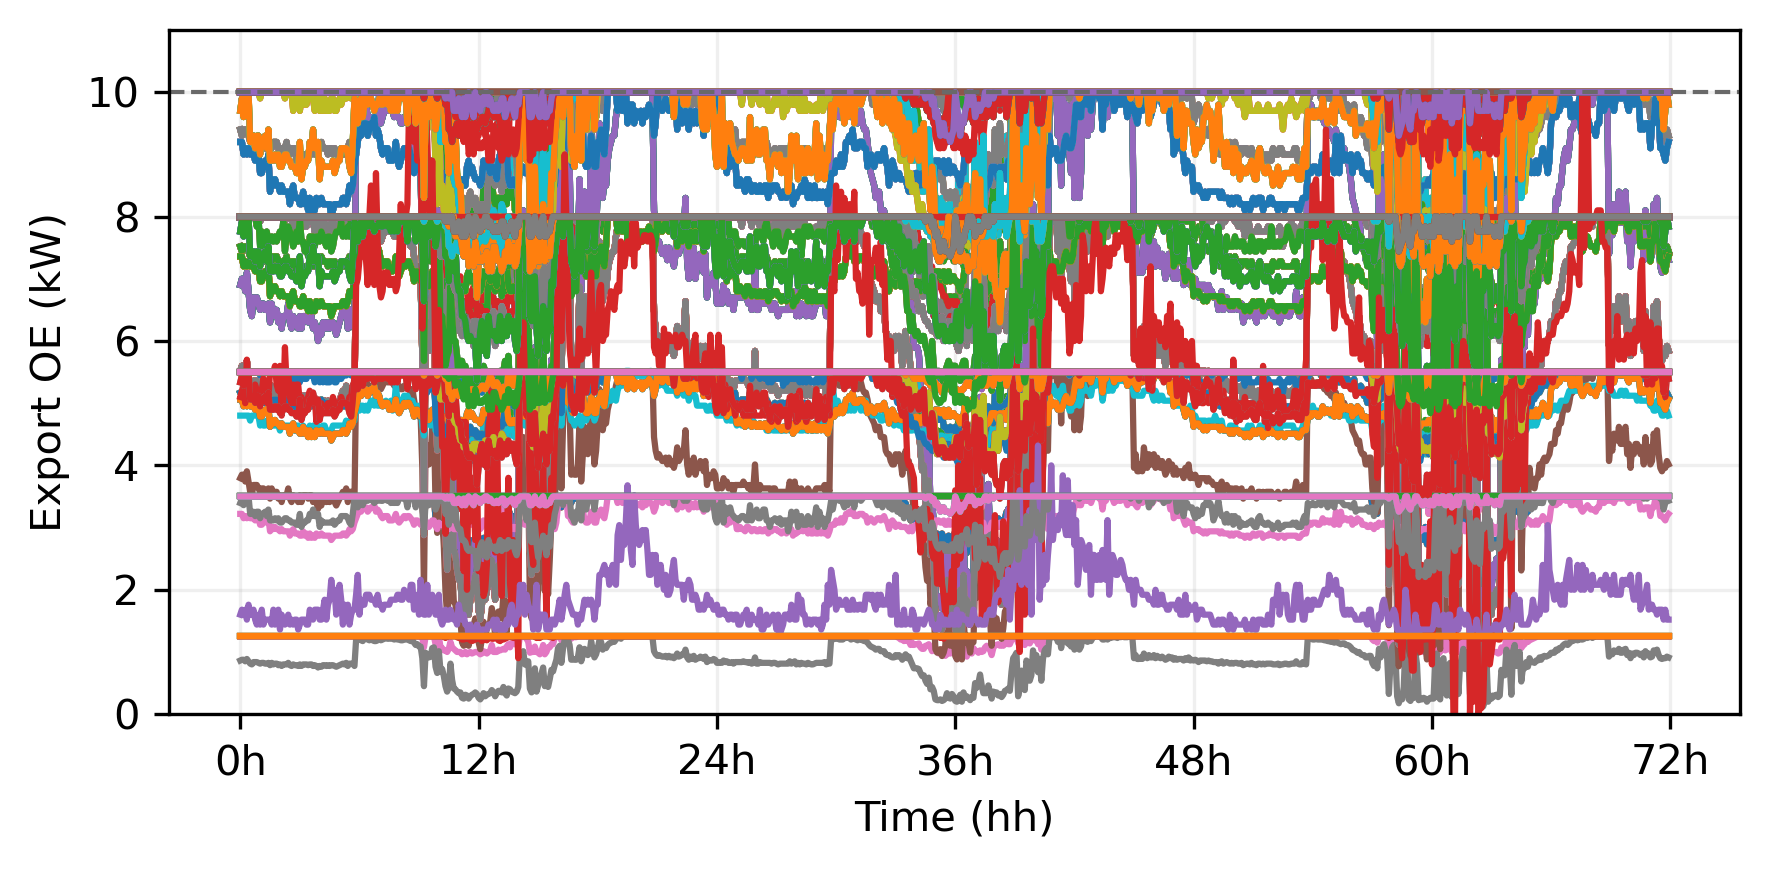

In [28]:
# plot the calculated operating envelopes for exports
x = range(num_time_steps*num_days)
y1 = [[]] * num_distr_tx
for itx in range(num_distr_tx):
    if len(ideal_oe_prop_exp_values[itx, 0]) > 0: 
        for ild in range(len(ideal_oe_prop_exp_values[itx, 0])):
            if ild == 0:
                y1[itx] = [[]] * len(ideal_oe_prop_exp_values[itx, 0])
            for itime in range(num_time_steps*num_days):
                if itime == 0:
                    y1[itx][ild] = []
                y1[itx][ild].append(ideal_oe_prop_exp_values[itx, itime][ild])

plt.figure(figsize=(6,3), dpi=300)
ax = plt.axes()
plt.ylabel("Export OE (kW)")
plt.xlabel("Time (hh)")
for itx in range(num_distr_tx):
    for ild in range(len(y1[itx])):
        plt.plot(x, y1[itx][ild], alpha=1)
plt.axhline(y = 10, color = 'dimgrey', linestyle = 'dashed', linewidth=1)
ax.set_xticks([0, 144, 288, 432, 576, 720, 864])
ax.set_xticklabels(['0h', '12h', '24h', '36h', '48h', '60h', '72h'])
plt.grid(alpha=0.2)
plt.ylim([0,11])
plt.tight_layout()
plt.show()


In the figure above, each solid line corresponds to the OE export value of a customer for the three simulated days (summer). For the OE export, each customer receives a different OE value that is proportional to its DER size. Since there are five different DER sizes in this network, it is posssible to see five straight lines on the figure, these straight lines correspond to flexible customers that received the maximum possible OE value for the entire three days of simulation. 

In addition, it is important to note that:
- This is the ideal operating envelope (best possible), so it is used as benchmark to the other simpler ones.
- The OE exports is lower during the day (~12h, ~36h, ~60h), when there is already PV generation on fixed customers, forcing the OE to be reduced for flexible customers.

#### Visualisation of the Calculated Ideal OE Import

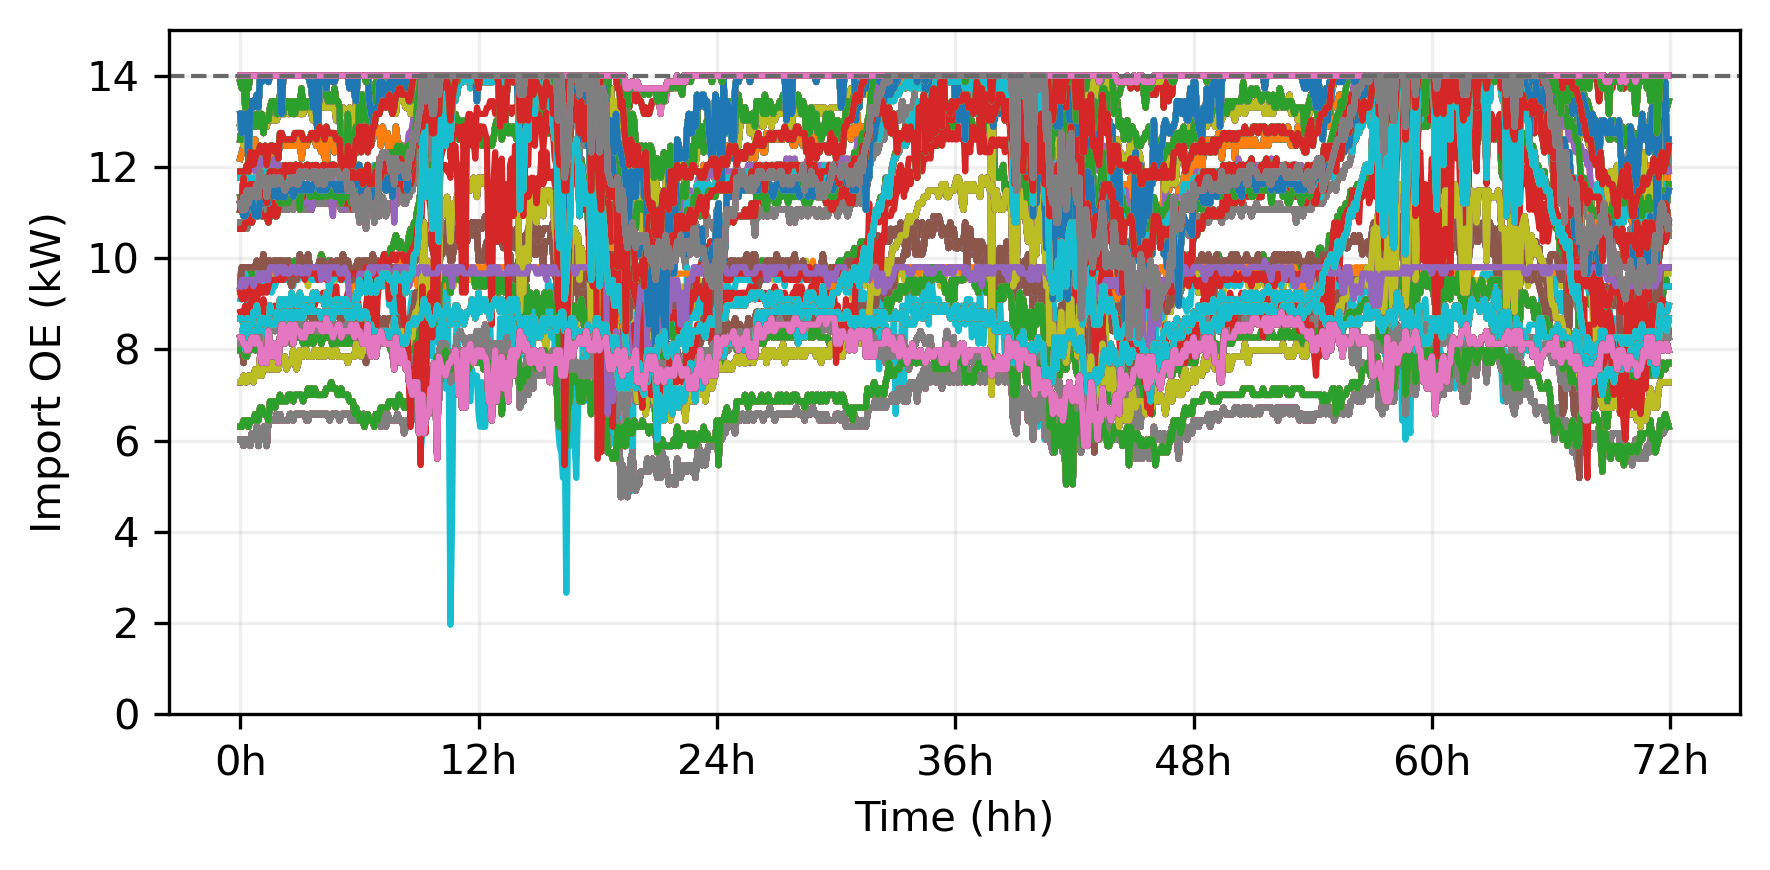

In [29]:
# plot the calculated operating envelopes for imports
x = range(num_time_steps*num_days)
y1 = [[]] * num_distr_tx
for itx in range(num_distr_tx):
    if len(ideal_oe_prop_exp_values[itx, 0]) > 0: 
        for ild in range(len(ideal_oe_prop_imp_values[itx, 0])):
            if ild == 0:
                y1[itx] = [[]] * len(ideal_oe_prop_imp_values[itx, 0])
            for itime in range(num_time_steps*num_days):
                if itime == 0:
                    y1[itx][ild] = []
                y1[itx][ild].append(ideal_oe_prop_imp_values[itx, itime][ild])

plt.figure(figsize=(6,3), dpi=300)
ax = plt.axes()
plt.ylabel("Import OE (kW)")
plt.xlabel("Time (hh)")
for itx in range(num_distr_tx):
    for ild in range(len(y1[itx])):
        plt.plot(x, y1[itx][ild], alpha=1)
plt.axhline(y = 14, color = 'dimgrey', linestyle = 'dashed', linewidth=1)
ax.set_xticks([0, 144, 288, 432, 576, 720, 864])
ax.set_xticklabels(['0h', '12h', '24h', '36h', '48h', '60h', '72h'])
plt.grid(alpha=0.2)
plt.ylim([0,15])
plt.tight_layout()
plt.show()

In the figure above, each solid line corresponds to the OE import value of a customer for the three simulated days (summer). For the OE imports, all customers are assumed to have the same maximum possible OE value which corresponds to the house fuse (14kW).

In addition, it is important to note that:
- This is the ideal operating envelope (best possible), so it is used as benchmark to the other simpler ones.
- The OE imports is lower during the evening, when the imports on the network are higher due to normal loads, forcing the OE to be reduced for flexible customers.

### 7. Performance Check of the Calculated Ideal OE
The calculated OE is implemented in OpenDSS (proxy of real network) to check how it would perform in the real network. Then, a technical assessment of the simulation results is carried out.

<span style="color:red">**<u>Note</u>.</span>** All active customers are assumed to be using the full available OE value calculated for them. So, it is the worst possible case.
#### Implementation of the Calculated Ideal OE Export

In [32]:
# Load the integrated HV-LV network (includes transformer, feeders, loads, PV systems, PV inverter settings, demands, PV generation)
dss_text.Command = 'Clear'
dss_text.Command = 'Compile ' + mydir + '/simulation_files/network/master.txt' 
dss_text.Command = 'Set VoltageBases=[66.0, 22.0, 0.400, 0.2309]'
dss_text.Command = 'calcv'
dss_text.Command = 'Set ControlMode=static'
dss_text.Command = 'Reset'                                                     
dss_text.Command = 'Set Mode=daily number=1 stepsize='+str(time_resolution)+'m' 

# Extract names of all lines from OpenDSS
line_names = dss_circuit.Lines.AllNames

# Extract names of all loads from the OpenDSS
load_names = dss_circuit.Loads.AllNames

# Extract names of all distribution transformers from the OpenDSS
transformer_names = dss_circuit.Transformers.AllNames

# initialise arrays to save simulation results for each time step
save_lvtx_util = np.zeros((num_distr_tx, num_time_steps*num_days), float) # save utilisation of all distribution transformers in the integrated HV-LV network
save_lines_util = np.zeros((len(line_names), 3, num_time_steps*num_days), float) # save utilisation of all lines in the integrated HV-LV network
save_all_voltage_profiles = np.zeros((len(load_names), num_time_steps*num_days), float) # save voltages of all customers connected to the integrated HV-LV network

# Implement the calculated OE value for each time step in a for loop
for itime in range(num_time_steps*num_days):
    
    dss_solution.Solve() # solve the power flow in OpenDSS

    
    for nlv in range(num_distr_tx): # loop in each existing LV network of the integrated HV-LV network
        if all_flex_cust_names_per_lv[nlv]: # check if there is any flexible customer on the LV network
            # Deactivate PV system element of flexible customers (OE export is going to be modelled as negative load next)
            for ild in range(len(all_flex_cust_names_per_lv[nlv])): # loop in each flexible customer of the LV network
                dss_circuit.SetActiveElement('pvsystem.pv_' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set the PV system active in OpenDSS
                dss_circuit.ActiveElement.Properties('enabled').Val = 'false' # deactivate PV system in OpenDSS
       
            # Implement the calculated operating envelopes to flexible customers
            for ild in range(len(all_flex_cust_names_per_lv[nlv])): # loop in each flexible customer of the LV network
                dss_circuit.SetActiveElement('load.' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set the flexible customer active in OpenDSS
                temp = dss_circuit.ActiveElement.Powers[1] # save the current reactive power of the active customer
                dss_circuit.ActiveElement.Properties('status').Val = 'fixed' # fix the load status to run with the set value instead of profile
                dss_circuit.ActiveElement.Properties('kw').Val = str(-1 * ideal_oe_prop_exp_values[nlv, itime][[ild]]) # set the kW to the allocated export OE value
                dss_circuit.ActiveElement.Properties('kvar').Val = str(temp) # set the kvar to be the same as before


    dss_solution.SolveSnap() # solve the power flow in OpenDSS without changing the time step
    
    
    
    # Distribution transformers utilisation 
    for itx in range(num_distr_tx): # loop in all distribution transformers of the integrated HV-LV network
        dss_circuit.SetActiveElement('transformer.' + str(transformer_names[itx+1])) # Set the distribution transformer active in OpenDSS
        number_phases = int(dss_circuit.ActiveElement.Properties('phases').Val) # Extract the number of phases of the distribution transformer from OpenDSS
        if number_phases == 3: # Extract power from three-phase distribution transformers
            P2_LVTx_temp = dss_circuit.ActiveElement.Powers[8] + dss_circuit.ActiveElement.Powers[10] + dss_circuit.ActiveElement.Powers[12] # Extract the three-phase active power at the secondary of the distribution transformer from OpenDSS
            Q2_LVTx_temp = dss_circuit.ActiveElement.Powers[9] + dss_circuit.ActiveElement.Powers[11] + dss_circuit.ActiveElement.Powers[13] # Extract the three-phase reactive power at the secondary of the distribution transformer from OpenDSS
            S2_LVTx_temp = np.sqrt(P2_LVTx_temp**2 + Q2_LVTx_temp**2) # Calculate the three-phase apparent power at the secondary of the distribution transformer
        if number_phases == 1: # Extract power from single-phase distribution transformers
            P2_LVTx_temp = dss_circuit.ActiveElement.Powers[4] # Extract the single-phase active power at the secondary of the distribution transformer from OpenDSS
            Q2_LVTx_temp = dss_circuit.ActiveElement.Powers[5] # Extract the single-phase reactive power at the secondary of the distribution transformer from OpenDSS
            S2_LVTx_temp = np.sqrt(P2_LVTx_temp**2 + Q2_LVTx_temp**2) # Calculate the single-phase apparent power at the secondary of the distribution transformer

        # calculate the utilisation of distribution transformers
        lv_tx_util_temp = 100 * S2_LVTx_temp / all_lvtx_capacity[itx]
        save_lvtx_util[itx, itime] = lv_tx_util_temp 
        
        

    # Lines utilisation (both HV and LV)
    for iln in range(len(line_names)): # loop in all lines of the integrated HV-LV network
        if (line_names[iln][8:10] == '5_' or line_names[iln][8:10] == '6_' or line_names[iln][8:10] == '9_' 
            or line_names[iln][8:10] == '10' or line_names[iln][8:10] == '12' or line_names[iln][8:10] == '15' 
            or line_names[iln][8:10] == '18' or line_names[iln][8:10] == '37' or line_names[iln][8:10] == '48'): # these are lines for commercial customers (they are never flexible customers in the case study), so no thermal issues
            pass
        else:
            line_util_temp = []
            dss_circuit.SetActiveElement('line.' + str(line_names[iln])) # Set the line active in OpenDSS
            Ia_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[0], 
                          dss_circuit.ActiveCktElement.CurrentsMagAng[6]) # Extract the current at phase A from the OpenDSS
            Ib_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[2], 
                          dss_circuit.ActiveCktElement.CurrentsMagAng[8]) # Extract the current at phase B from the OpenDSS
            Ic_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[4], 
                          dss_circuit.ActiveCktElement.CurrentsMagAng[10]) # Extract the current at phase C from the OpenDSS
            I_phase_capacity = dss_circuit.Lines.NormAmps # Extract the rated capacity (amps) of the line (per phase)

            # calculate the line utilisation in each phase
            line_util_temp.append(100 * (Ia_temp / I_phase_capacity))
            line_util_temp.append(100 * (Ib_temp / I_phase_capacity))
            line_util_temp.append(100 * (Ic_temp / I_phase_capacity))
            save_lines_util[iln, :, itime] = line_util_temp



    # Voltages at all customers of the integrated HV-LV network
    for ild in range(len(load_names)): # loop in all customers of the integrated HV-LV network
        dss_circuit.SetActiveElement('load.' + str(load_names[ild])) # Set the customer active in OpenDSS
        temp_v = dss_circuit.ActiveElement.VoltagesMagAng # Extract the voltage at the customer from OpenDSS
        save_all_voltage_profiles[ild, itime] = temp_v[0]


        
    # Reset flexible customers to their original settings for the next time step
    for nlv in range(79):
        if all_flex_cust_names_per_lv[nlv]: # check if there is any flexible customer in the LV network
            # Reactivate PV systems for flexible customers
            for ild in range(len(all_flex_cust_names_per_lv[nlv])):
                dss_circuit.SetActiveElement('pvsystem.pv_' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set PV system active in OpenDSS
                dss_circuit.ActiveElement.Properties('enabled').Val = 'true' # Reactivate the PV system
    
            # Reset flexible customers to profile values for the next time step
            default_kw_kvar = 1
            for ild in range(len(all_flex_cust_names_per_lv[nlv])): # loop in all customers of the LV network
                dss_circuit.SetActiveElement('load.' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set customer active in OpenDSS
                dss_circuit.ActiveElement.Properties('status').Val = 'variable' # Set the load to follow its original profile
                dss_circuit.ActiveElement.Properties('kw').Val = str(default_kw_kvar)
                dss_circuit.ActiveElement.Properties('kvar').Val = str(default_kw_kvar)

#### Technical Assessment of the Calculated Ideal OE Export

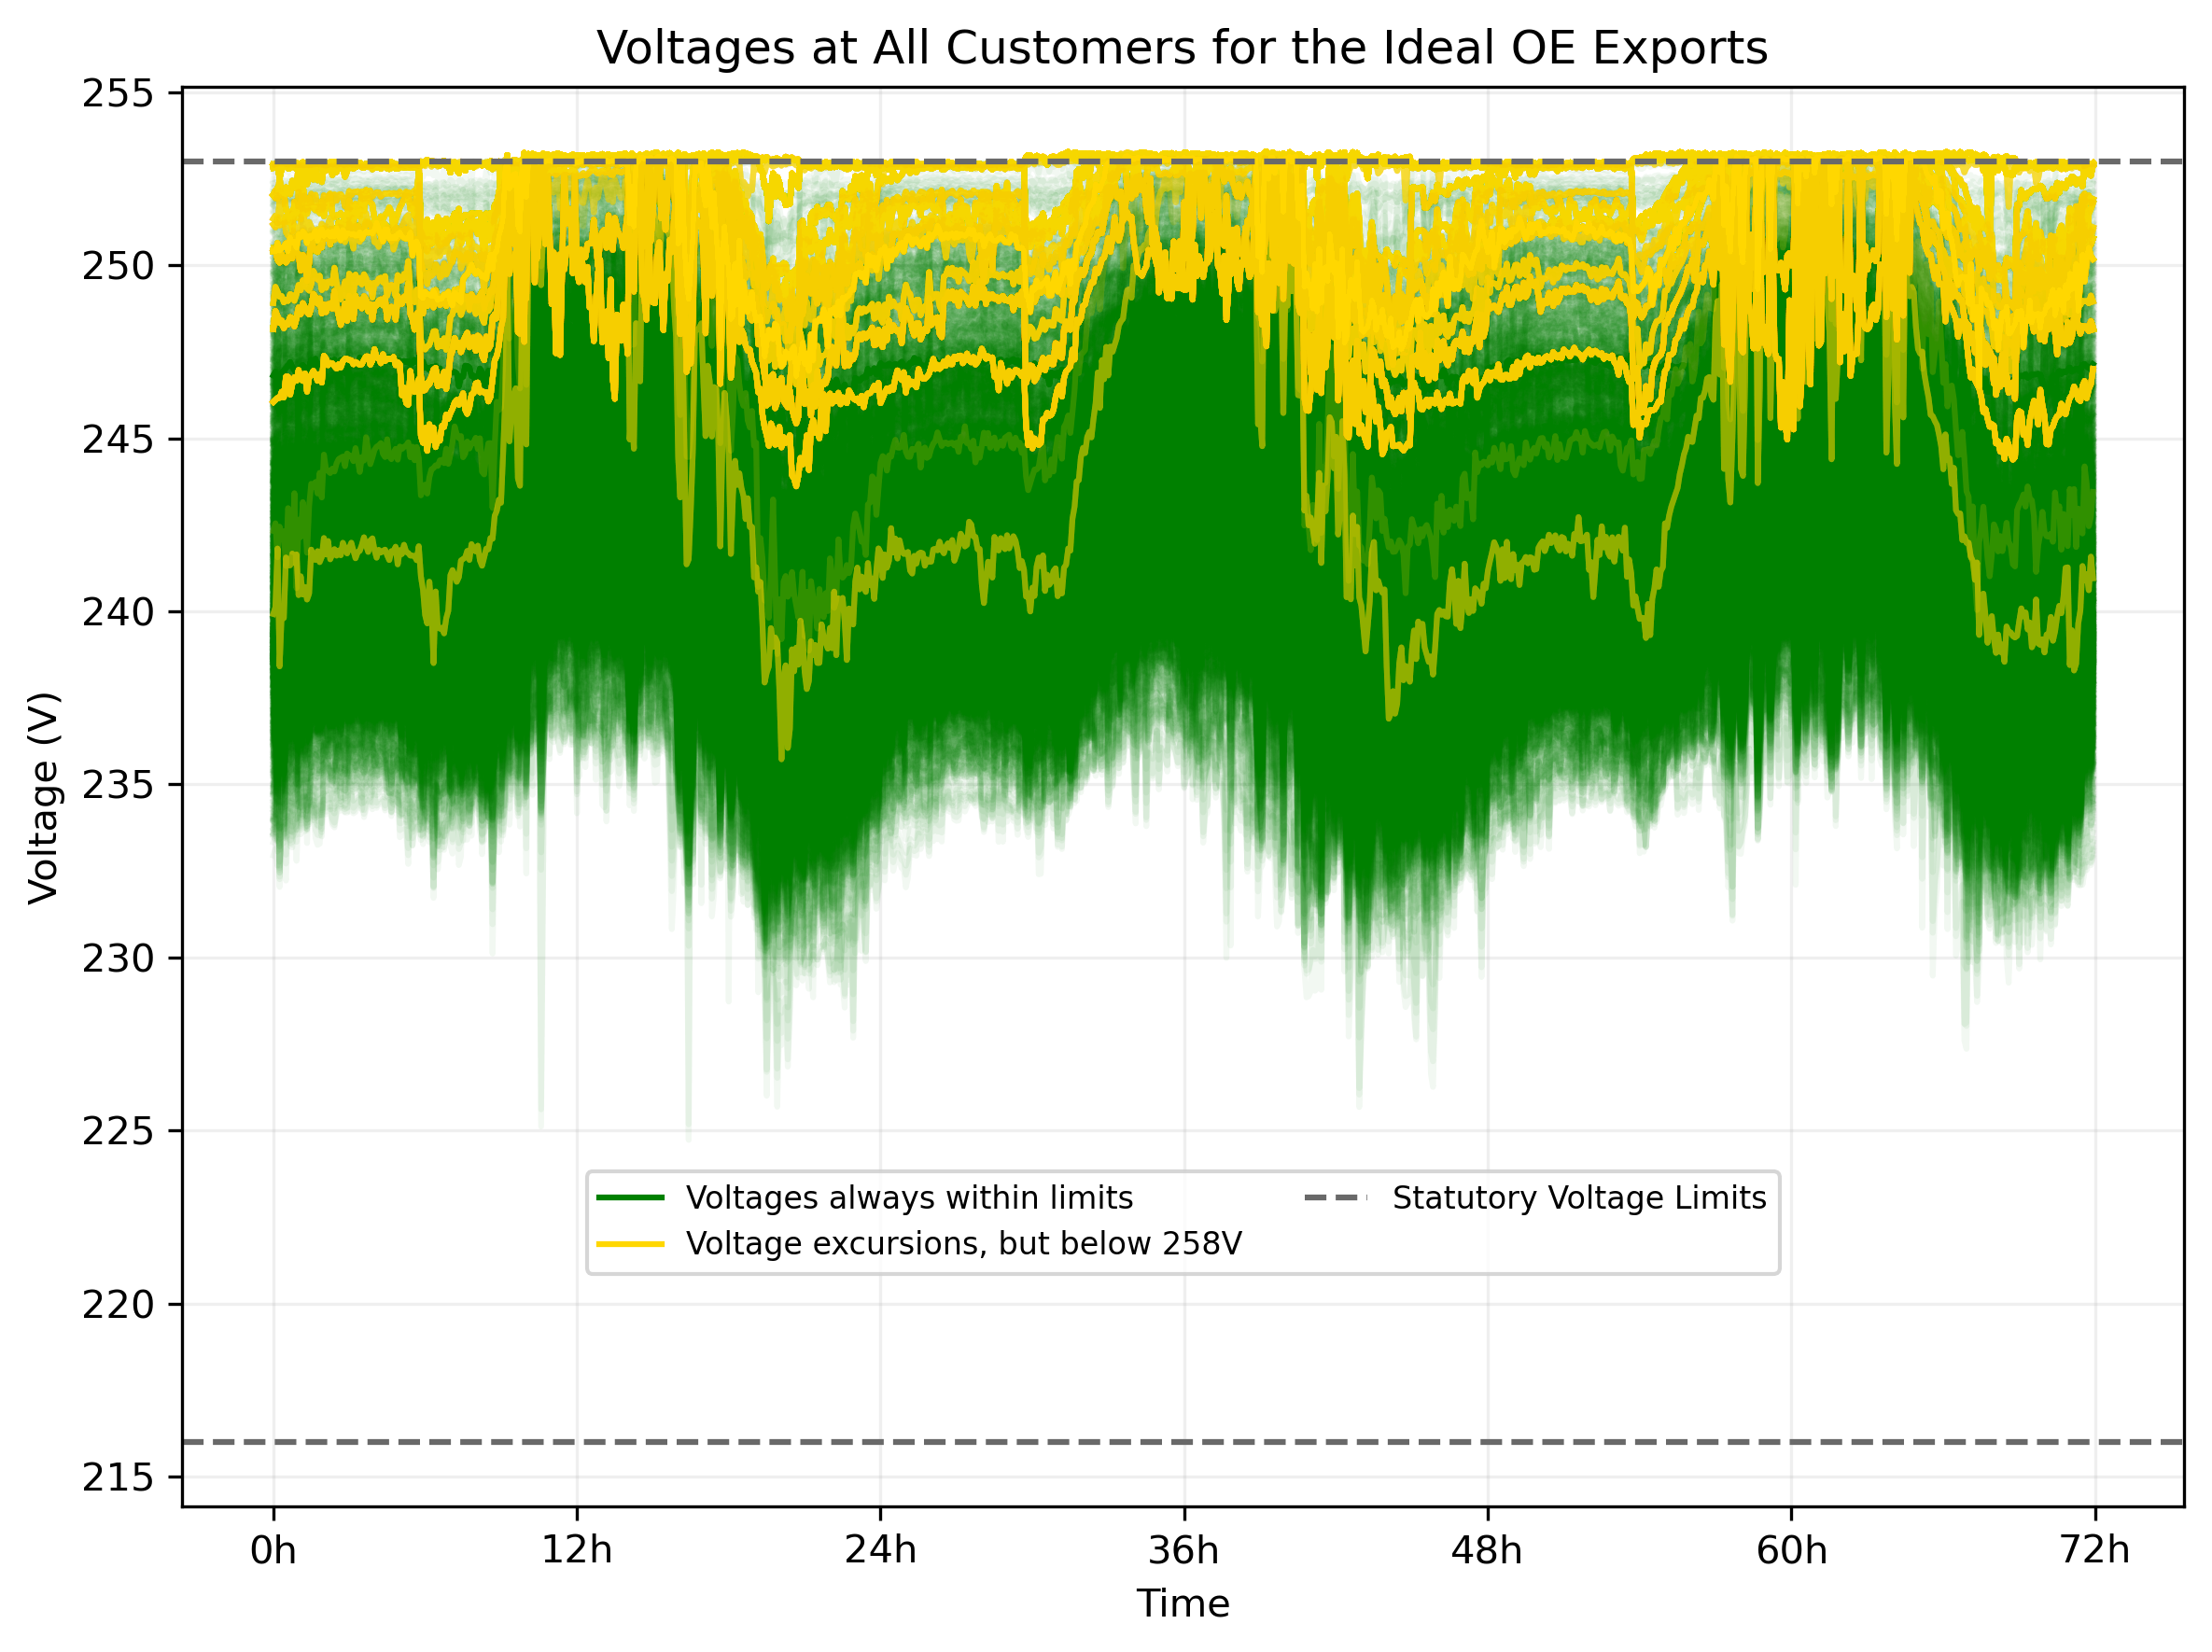

The network-wide voltage compliance is: 100.0%


In [52]:
# Calculation of the network-wide voltage compliance
v_all_cust_10min = np.zeros((len(load_names), int(num_time_steps*num_days/2)), float)
v_all_cust_10min_sorted = np.zeros((len(load_names), int(num_time_steps*num_days/2)), float)
count = 0
for ild in range(len(load_names)): # loop in all customers of the integrated HV-LV network
    for itime in range(int(num_time_steps*num_days/2)): 
        # calculate the 10 minutes voltage equivalent (current time step is of 5 minutes)
        v_all_cust_10min[ild, itime] = (save_all_voltage_profiles[ild, 2*itime] + save_all_voltage_profiles[ild, 2*itime+1]) / 2
    v_all_cust_10min_sorted[ild,:] = np.sort(v_all_cust_10min[ild, :]) # sort the voltages of each customer from small to high
    # check if the 99 percentile if outside the limits
    if (v_all_cust_10min_sorted[ild, 142] > 253) or (v_all_cust_10min_sorted[ild, 1] < 216):
        count += 1 # if outside the limits, count the customer as non-compliant

v_network_compliance = (1 - ((count) / len(load_names))) * 100 # calculate the network-wide voltage compliance



# Plot voltages in all customers
x = range(num_time_steps*num_days)
y1 = save_all_voltage_profiles
y2 = np.where(y1 > 253.1)
y3 = np.where(y1 > 258.1)

plt.figure(figsize=(8, 6), dpi=300)
ax = plt.axes()
plt.title("Voltages at All Customers for the Ideal OE Exports")
plt.ylabel("Voltage (V)")
plt.xlabel("Time")
for ild in range(len(load_names)):
    if ild == 0:
        plt.plot(x, y1[ild, :], color="green", label='Voltages always within limits')
    else:
        plt.plot(x, y1[ild, :], color="green", alpha=0.05)
for i in range(len(y2[0])):
    if i == 0:
        plt.plot(x, y1[y2[0][i]], color="gold", label='Voltage excursions, but below 258V')
    else:
        plt.plot(x, y1[y2[0][i]], color="gold", alpha=0.1)
for i in range(len(y3[0])):
    if i == 0:
        plt.plot(x, y1[y3[0][i]], color="red", label='Voltages excursions above 258V')
    else:
        plt.plot(x, y1[y3[0][i]], color="red", alpha=0.05)
plt.axhline(y = 253, color = 'dimgrey', linestyle = 'dashed', label='Statutory Voltage Limits')
plt.axhline(y = 216, color = 'dimgrey', linestyle = 'dashed')
plt.grid(alpha=0.2)
ax.set_xticks([0, 144, 288, 432, 576, 720, 864])
ax.set_xticklabels(['0h', '12h', '24h', '36h', '48h', '60h', '72h'])
plt.legend(loc='center', ncol=2, fontsize=8, bbox_to_anchor=(0.5, 0.2, 0, 0))
plt.tight_layout()
plt.show()


print('The network-wide voltage compliance is: '+str(v_network_compliance)+'%')


NEEDS TO BE UPDATED!!!

Few comments about the info above:
- Customers' voltages are always within limits when the Ideal OE Export is used.
- The network-wide voltage compliance (which includes the HV feeder and all LV networks) is 100%.
- The Ideal OE Exports with Integrated HV-LV Calculation was able to avoid all voltage issues of customers.

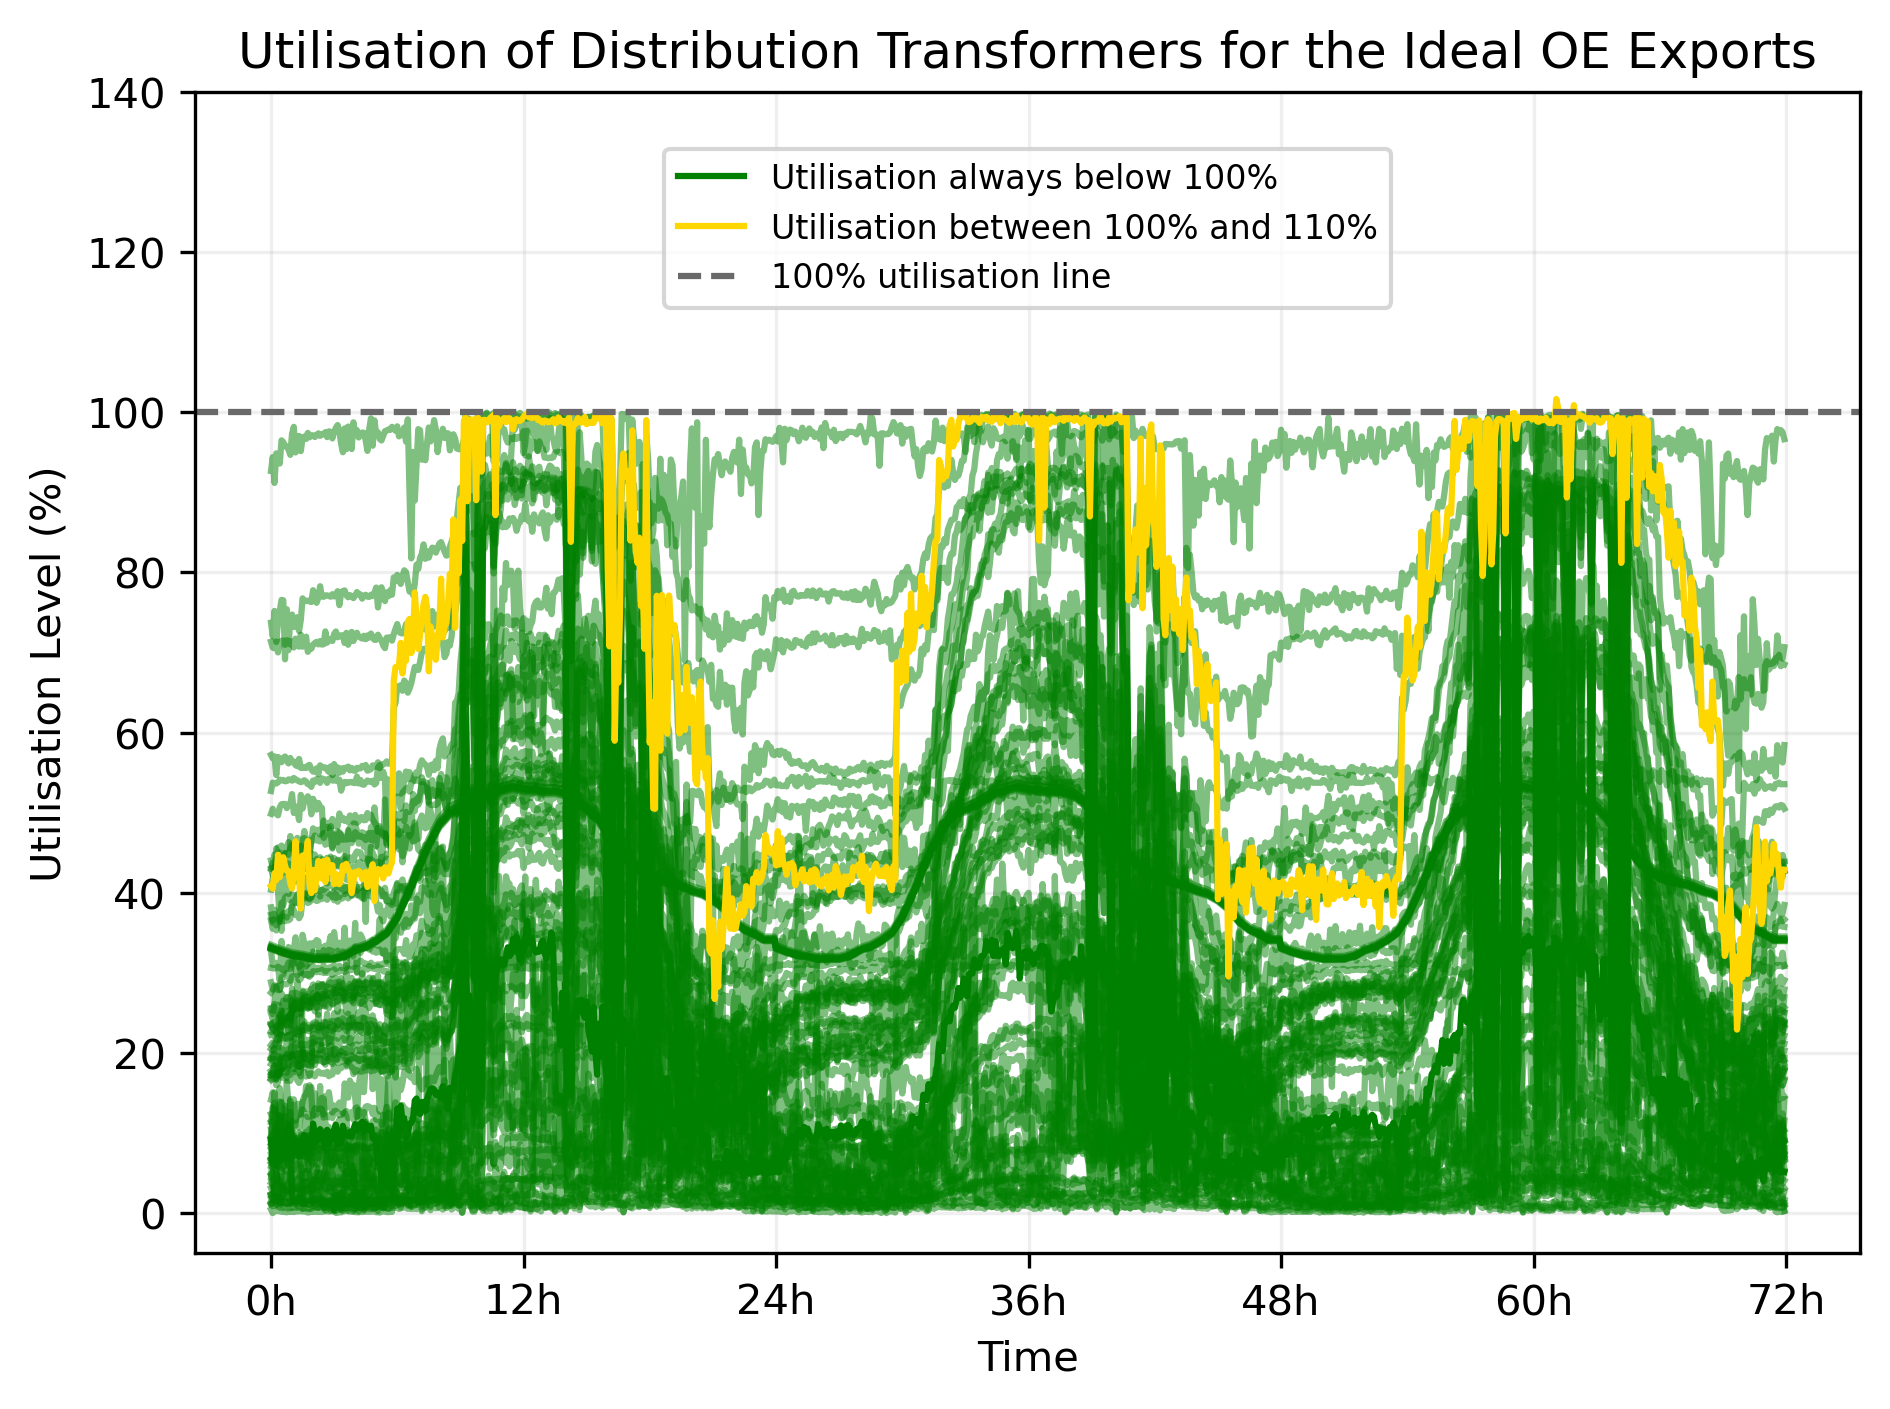

In [53]:
# Plot utilisation of all distribution transformers
x = range(num_time_steps*num_days)
y1 = save_lvtx_util
red_count = 0
yellow_count = 0
green_count = 0

plt.figure(dpi=300)
ax = plt.axes()
plt.title("Utilisation of Distribution Transformers for the Ideal OE Exports")
plt.ylabel("Utilisation Level (%)")
plt.xlabel("Time")
for itx in range(num_distr_tx):
    if (y1[itx] <= 100.49).all():
        if green_count == 0:
            plt.plot(x, y1[itx], color='green', alpha=1, label='Utilisation always below 100%') 
            green_count += 1
        else:
            plt.plot(x, y1[itx], color='green', alpha=0.5)
for itx in range(num_distr_tx):    
    if (y1[itx] > 100.49).any() and (y1[itx] <= 110.49).all():
        if yellow_count == 0:
            plt.plot(x, y1[itx], color='gold', alpha=1, label='Utilisation between 100% and 110%') 
            yellow_count += 1
        else:
            plt.plot(x, y1[itx], color='gold', alpha=0.75)
for itx in range(num_distr_tx):    
    if (y1[itx] > 110.49).any():
        if red_count == 0:
            plt.plot(x, y1[itx], color='red', alpha=1, label='Utilisation above 110%') 
            red_count =+ 1
        else:
            plt.plot(x, y1[itx], color='red', alpha=0.75)
plt.axhline(y = 100, color = 'dimgrey', linestyle = 'dashed', label='100% utilisation line')
plt.grid(alpha=0.2)
plt.ylim(-5, 140)
ax.set_xticks([0, 144, 288, 432, 576, 720, 864])
ax.set_xticklabels(['0h', '12h', '24h', '36h', '48h', '60h', '72h'])
plt.legend(loc='lower center', fontsize=8, bbox_to_anchor=(0.5, 0.8, 0, 0))
plt.tight_layout()
plt.show()

Few comments about the figure above:
- The utilisation of almost all distribution transformers are always within the required limits.
- Only one distribution transformer passes the 100% utilisation. It is a situation where OEs cannot help with, since it has problems even with the OE being equal to zero. However, it is only 2% above the limit and for a very short period, which is perfectly acceptable under real operational conditions.
- The Ideal OE Exports with Integrated HV-LV Calculation could solve almost all thermal issues in distribution transformers.

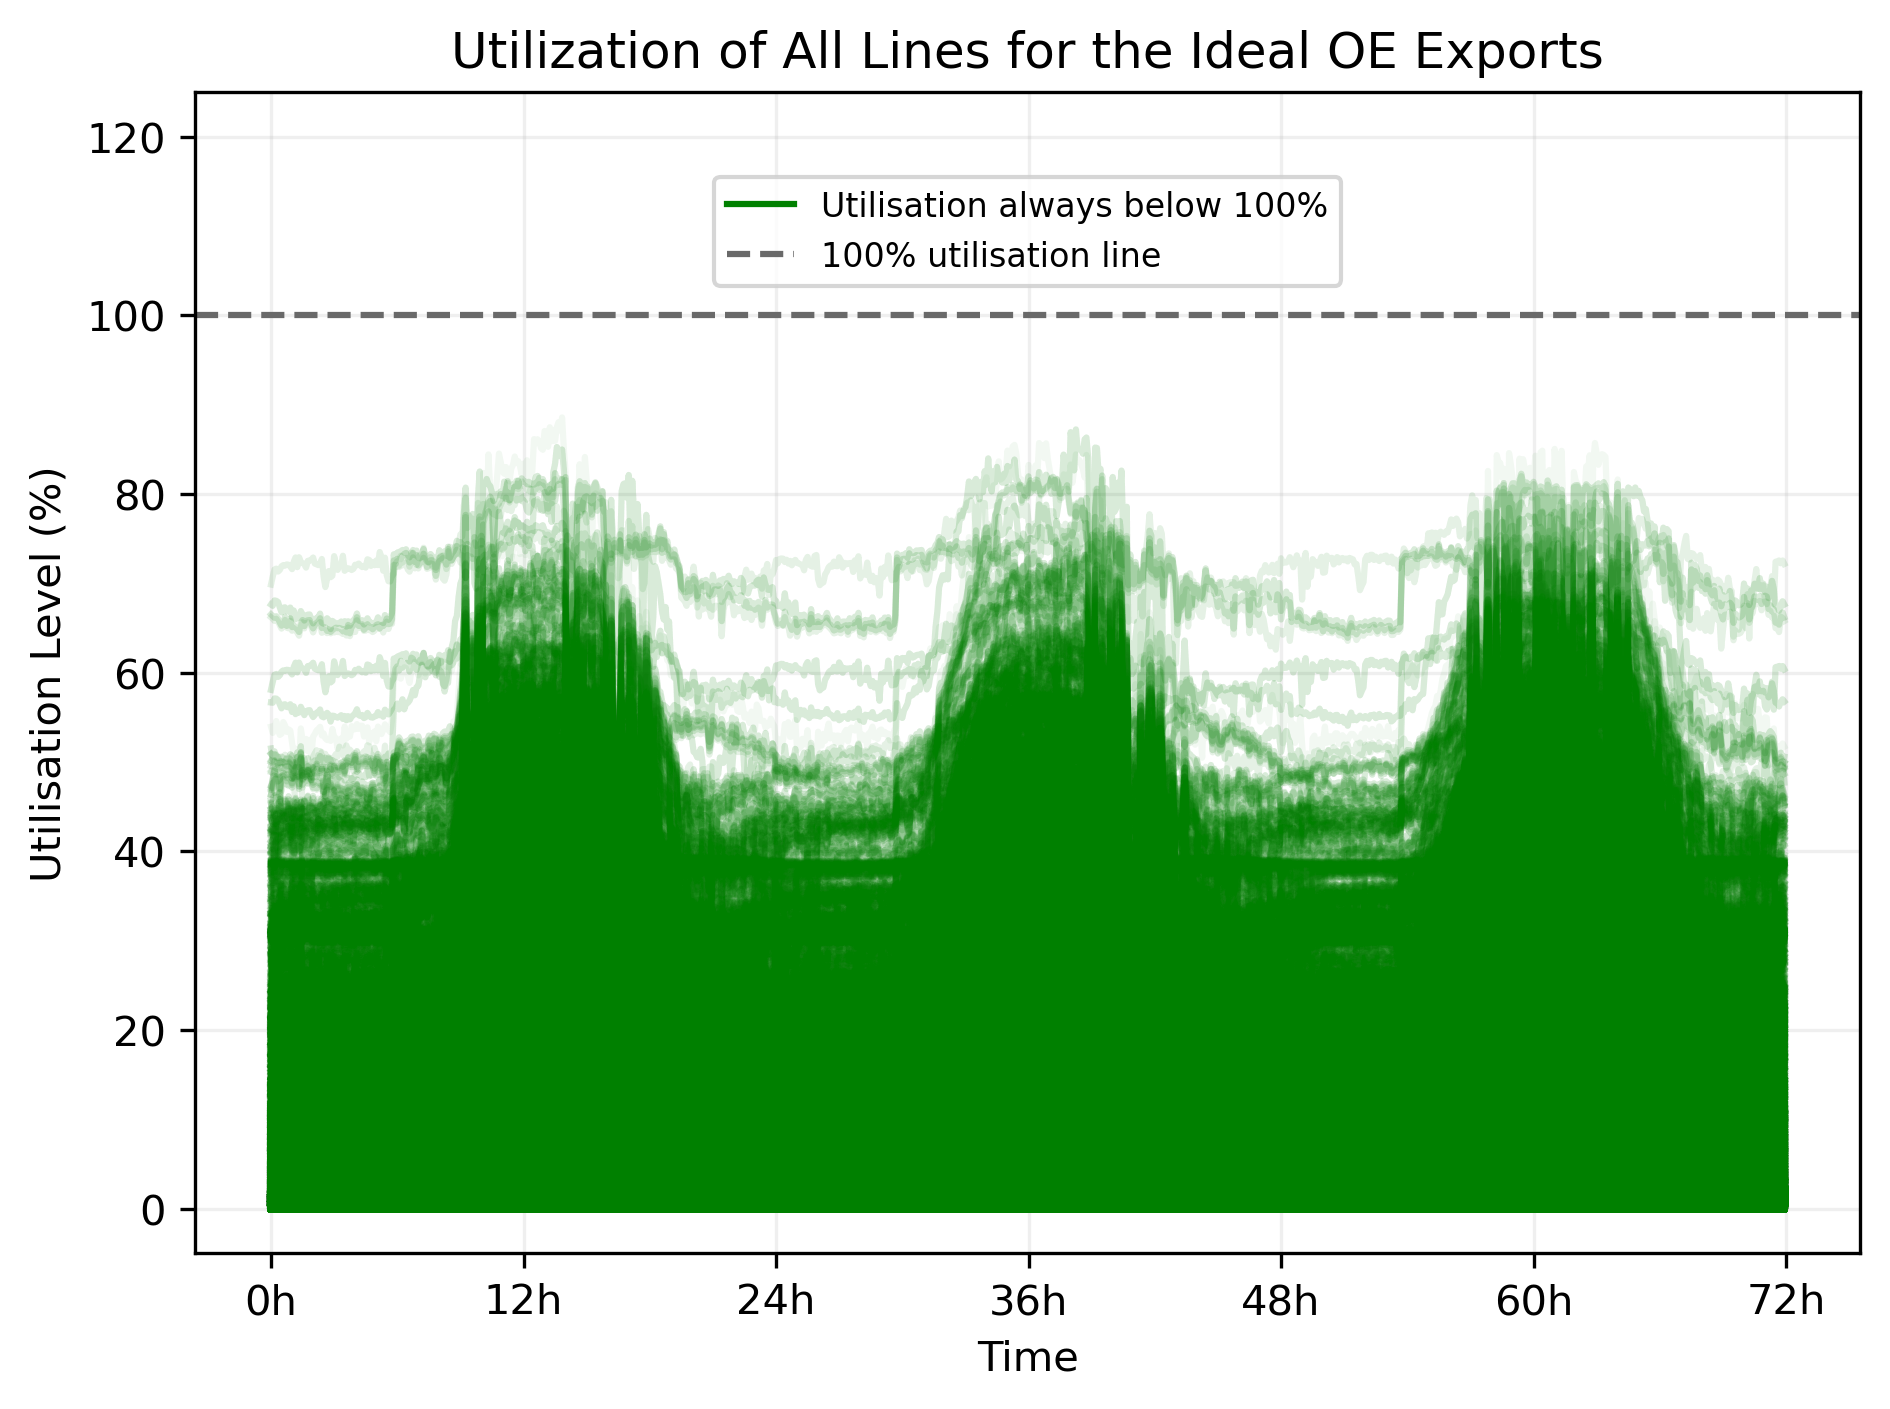

In [60]:
# Plot utilisation of all HV and LV lines
x = range(num_time_steps*num_days)
y1 = save_lines_util
green_count = 0
yellow_count = 0
red_count = 0

plt.figure(dpi=300)
ax = plt.axes()
plt.title("Utilization of All Lines for the Ideal OE Exports")
plt.ylabel("Utilisation Level (%)")
plt.xlabel("Time")
for iln in range(len(y1)):
    for iph in range(3):
        if (y1[iln, iph, :] <= 100.49).all():
            if green_count == 0:
                plt.plot(x, y1[iln, iph, :], color='green', alpha=1, label='Utilisation always below 100%') 
                green_count += 1
            else:
                plt.plot(x, y1[iln, iph, :], color='green', alpha=0.05)
for iln in range(len(y1)):    
    for iph in range(3):
        if (y1[iln, iph, :] > 100.49).any() and (y1[iln, iph, :] <= 110.49).all():
            if yellow_count == 0:
                plt.plot(x, y1[iln, iph, :], color='gold', alpha=1, label='Utilisation between 100% and 110%') 
                yellow_count += 1
            else:
                plt.plot(x, y1[iln, iph, :], color='gold', alpha=0.2)
for iln in range(len(y1)):    
    for iph in range(3):
        if (y1[iln, iph, :] > 110.49).any():
            if red_count == 0:
                plt.plot(x, y1[iln, iph, :], color='red', alpha=1, label='Utilisation above 110%') 
                red_count =+ 1
            else:
                plt.plot(x, y1[iln, iph, :], color='red', alpha=0.2)
plt.axhline(y = 100, color = 'dimgrey', linestyle = 'dashed', label='100% utilisation line')
plt.grid(alpha=0.2)
plt.ylim(-5, 125)
ax.set_xticks([0, 144, 288, 432, 576, 720, 864])
ax.set_xticklabels(['0h', '12h', '24h', '36h', '48h', '60h', '72h'])
plt.legend(loc='center', fontsize=8, bbox_to_anchor=(0.5, 0.88, 0, 0))
plt.tight_layout()
plt.show()

Comments about the figure above:
- The utilisation of all HV and LV lines are always within the required limits.
- The Ideal OE Exports with Integrated HV-LV Calculation was able to avoid any thermal issues on HV and LV lines.

#### Implementation of the Calculated Ideal OE Import

In [62]:
# Re-load the integrated HV-LV network (includes transformer, feeders, loads, PV systems, PV inverter settings, demands, PV generation)
dss_text.Command = 'Clear'
dss_text.Command = 'Compile ' + mydir + '/simulation_files/network/master.txt' 
dss_text.Command = 'Set VoltageBases=[66.0, 22.0, 0.400, 0.2309]'
dss_text.Command = 'calcv'
dss_text.Command = 'Set ControlMode=static'
dss_text.Command = 'Reset'                                                     
dss_text.Command = 'Set Mode=daily number=1 stepsize='+str(time_resolution)+'m' 

# Extract names of all lines from OpenDSS
line_names = dss_circuit.Lines.AllNames

# Extract names of all loads from the OpenDSS
load_names = dss_circuit.Loads.AllNames

# Extract names of all distribution transformers from the OpenDSS
transformer_names = dss_circuit.Transformers.AllNames

# initialise arrays to save simulation results for each time step
save_lvtx_util = np.zeros((num_distr_tx, num_time_steps*num_days), float) # save utilisation of all distribution transformers in the integrated HV-LV network
save_lines_util = np.zeros((len(line_names), 3, num_time_steps*num_days), float) # save utilisation of all lines in the integrated HV-LV network
save_all_voltage_profiles = np.zeros((len(load_names), num_time_steps*num_days), float) # save voltages of all customers connected to the integrated HV-LV network

# Implement the calculated OE value for each time step in a for loop
for itime in range(num_time_steps*num_days):
    
    dss_solution.Solve() # solve the power flow in OpenDSS

    
    for nlv in range(num_distr_tx): # loop in each existing LV network of the integrated HV-LV network
        if all_flex_cust_names_per_lv[nlv]: # check if there is any flexible customer on the LV network
            # Deactivate PV system element of flexible customers (OE export is going to be modelled as negative load next)
            for ild in range(len(all_flex_cust_names_per_lv[nlv])): # loop in each flexible customer of the LV network
                dss_circuit.SetActiveElement('pvsystem.pv_' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set the PV system active in OpenDSS
                dss_circuit.ActiveElement.Properties('enabled').Val = 'false' # deactivate PV system in OpenDSS
       
            # Implement the calculated operating envelopes to flexible customers
            for ild in range(len(all_flex_cust_names_per_lv[nlv])): # loop in each flexible customer of the LV network
                dss_circuit.SetActiveElement('load.' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set the flexible customer active in OpenDSS
                temp = dss_circuit.ActiveElement.Powers[1] # save the current reactive power of the active customer
                dss_circuit.ActiveElement.Properties('status').Val = 'fixed' # fix the load status to run with the set value instead of profile
                dss_circuit.ActiveElement.Properties('kw').Val = str(ideal_oe_prop_imp_values[nlv, itime][[ild]]) # set the kW to the allocated import OE value
                dss_circuit.ActiveElement.Properties('kvar').Val = str(temp) # set the kvar to be the same as before


    dss_solution.SolveSnap() # solve the power flow in OpenDSS without changing the time step
    
    
    
    # Distribution transformers utilisation 
    for itx in range(num_distr_tx): # loop in all distribution transformers of the integrated HV-LV network
        dss_circuit.SetActiveElement('transformer.' + str(transformer_names[itx+1])) # Set the distribution transformer active in OpenDSS
        number_phases = int(dss_circuit.ActiveElement.Properties('phases').Val) # Extract the number of phases of the distribution transformer from OpenDSS
        if number_phases == 3: # Extract power from three-phase distribution transformers
            P2_LVTx_temp = dss_circuit.ActiveElement.Powers[8] + dss_circuit.ActiveElement.Powers[10] + dss_circuit.ActiveElement.Powers[12] # Extract the three-phase active power at the secondary of the distribution transformer from OpenDSS
            Q2_LVTx_temp = dss_circuit.ActiveElement.Powers[9] + dss_circuit.ActiveElement.Powers[11] + dss_circuit.ActiveElement.Powers[13] # Extract the three-phase reactive power at the secondary of the distribution transformer from OpenDSS
            S2_LVTx_temp = np.sqrt(P2_LVTx_temp**2 + Q2_LVTx_temp**2) # Calculate the three-phase apparent power at the secondary of the distribution transformer
        if number_phases == 1: # Extract power from single-phase distribution transformers
            P2_LVTx_temp = dss_circuit.ActiveElement.Powers[4] # Extract the single-phase active power at the secondary of the distribution transformer from OpenDSS
            Q2_LVTx_temp = dss_circuit.ActiveElement.Powers[5] # Extract the single-phase reactive power at the secondary of the distribution transformer from OpenDSS
            S2_LVTx_temp = np.sqrt(P2_LVTx_temp**2 + Q2_LVTx_temp**2) # Calculate the single-phase apparent power at the secondary of the distribution transformer

        # calculate the utilisation of distribution transformers
        lv_tx_util_temp = 100 * S2_LVTx_temp / all_lvtx_capacity[itx]
        save_lvtx_util[itx, itime] = lv_tx_util_temp 
        
        

    # Lines utilisation (both HV and LV)
    for iln in range(len(line_names)): # loop in all lines of the integrated HV-LV network
        if (line_names[iln][8:10] == '5_' or line_names[iln][8:10] == '6_' or line_names[iln][8:10] == '9_' 
            or line_names[iln][8:10] == '10' or line_names[iln][8:10] == '12' or line_names[iln][8:10] == '15' 
            or line_names[iln][8:10] == '18' or line_names[iln][8:10] == '37' or line_names[iln][8:10] == '48'): # these are lines for commercial customers (they are never flexible customers in the case study), so no thermal issues
            pass
        else:
            line_util_temp = []
            dss_circuit.SetActiveElement('line.' + str(line_names[iln])) # Set the line active in OpenDSS
            Ia_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[0], 
                          dss_circuit.ActiveCktElement.CurrentsMagAng[6]) # Extract the current at phase A from the OpenDSS
            Ib_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[2], 
                          dss_circuit.ActiveCktElement.CurrentsMagAng[8]) # Extract the current at phase B from the OpenDSS
            Ic_temp = max(dss_circuit.ActiveCktElement.CurrentsMagAng[4], 
                          dss_circuit.ActiveCktElement.CurrentsMagAng[10]) # Extract the current at phase C from the OpenDSS
            I_phase_capacity = dss_circuit.Lines.NormAmps # Extract the rated capacity (amps) of the line (per phase)

            # calculate the line utilisation in each phase
            line_util_temp.append(100 * (Ia_temp / I_phase_capacity))
            line_util_temp.append(100 * (Ib_temp / I_phase_capacity))
            line_util_temp.append(100 * (Ic_temp / I_phase_capacity))
            save_lines_util[iln, :, itime] = line_util_temp



    # Voltages at all customers of the integrated HV-LV network
    for ild in range(len(load_names)): # loop in all customers of the integrated HV-LV network
        dss_circuit.SetActiveElement('load.' + str(load_names[ild])) # Set the customer active in OpenDSS
        temp_v = dss_circuit.ActiveElement.VoltagesMagAng # Extract the voltage at the customer from OpenDSS
        save_all_voltage_profiles[ild, itime] = temp_v[0]



    # Reset flexible customers to their original settings for the next time step
    for nlv in range(79):
        if all_flex_cust_names_per_lv[nlv]: # check if there is any flexible customer in the LV network
            # Reactivate PV systems for flexible customers
            for ild in range(len(all_flex_cust_names_per_lv[nlv])):
                dss_circuit.SetActiveElement('pvsystem.pv_' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set PV system active in OpenDSS
                dss_circuit.ActiveElement.Properties('enabled').Val = 'true' # Reactivate the PV system
    
            # Reset flexible customers to profile values for the next time step
            default_kw_kvar = 1
            for ild in range(len(all_flex_cust_names_per_lv[nlv])): # loop in all customers of the LV network
                dss_circuit.SetActiveElement('load.' + str(all_flex_cust_names_per_lv[nlv][ild])) # Set customer active in OpenDSS
                dss_circuit.ActiveElement.Properties('status').Val = 'variable' # Set the load to follow its original profile
                dss_circuit.ActiveElement.Properties('kw').Val = str(default_kw_kvar)
                dss_circuit.ActiveElement.Properties('kvar').Val = str(default_kw_kvar)

#### Technical Assessment of the Calculated Ideal OE import

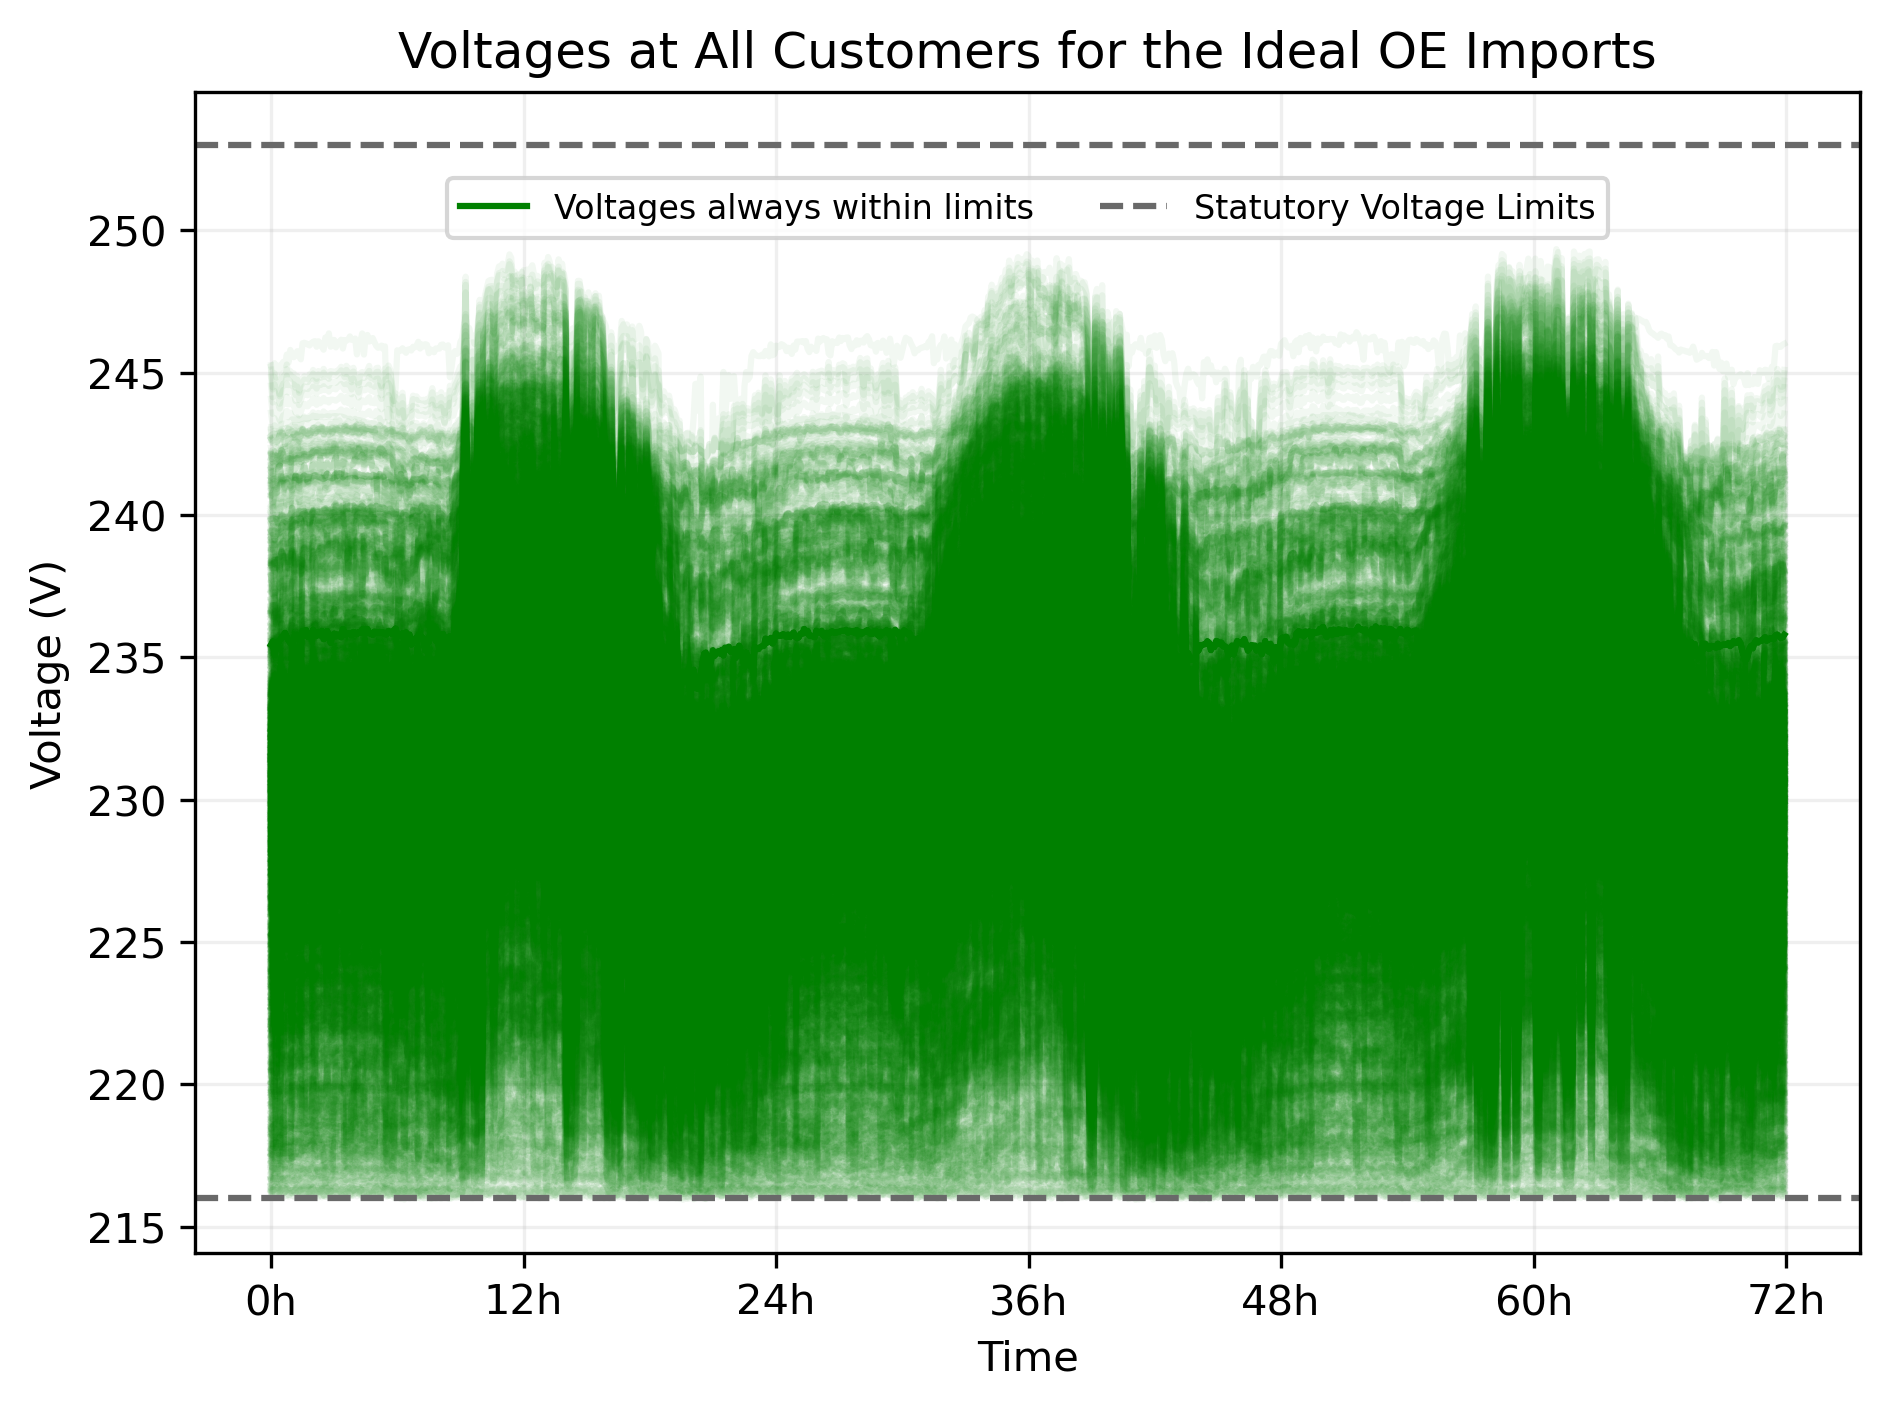

The network-wide voltage compliance is: 100.0%


In [75]:
# Calculation of the network-wide voltage compliance
v_all_cust_10min = np.zeros((len(load_names), int(num_time_steps*num_days/2)), float)
v_all_cust_10min_sorted = np.zeros((len(load_names), int(num_time_steps*num_days/2)), float)
count = 0
for ild in range(len(load_names)): # loop in all customers of the integrated HV-LV network
    for itime in range(int(num_time_steps*num_days/2)): 
        # calculate the 10 minutes voltage equivalent (current time step is of 5 minutes)
        v_all_cust_10min[ild, itime] = (save_all_voltage_profiles[ild, 2*itime] + save_all_voltage_profiles[ild, 2*itime+1]) / 2
    v_all_cust_10min_sorted[ild,:] = np.sort(v_all_cust_10min[ild, :]) # sort the voltages of each customer from small to high
    # check if the 99 percentile if outside the limits
    if (v_all_cust_10min_sorted[ild, 428] > 253) or (v_all_cust_10min_sorted[ild, 4] < 216):
        count += 1 # if outside the limits, count the customer as non-compliant

v_network_compliance = (1 - ((count) / len(load_names))) * 100 # calculate the network-wide voltage compliance



# Plot voltages in all customers
x = range(num_time_steps*num_days)
y1 = save_all_voltage_profiles
y2 = np.where(y1 < 215.9)
y3 = np.where(y1 < 206.9)

plt.figure(dpi=300)
ax = plt.axes()
plt.title("Voltages at All Customers for the Ideal OE Imports")
plt.ylabel("Voltage (V)")
plt.xlabel("Time")
for ild in range(len(load_names)):
    if ild == 0:
        plt.plot(x, y1[ild, :], color="green", label='Voltages always within limits')
    else:
        plt.plot(x, y1[ild, :], color="green", alpha=0.05)
for i in range(len(y2[0])):
    if i == 0:
        plt.plot(x, y1[y2[0][i]], color="gold", label='Voltage excursions, but below 258V')
    else:
        plt.plot(x, y1[y2[0][i]], color="gold", alpha=0.1)
for i in range(len(y3[0])):
    if i == 0:
        plt.plot(x, y1[y3[0][i]], color="red", label='Voltages excursions above 258V')
    else:
        plt.plot(x, y1[y3[0][i]], color="red", alpha=0.05)
plt.axhline(y = 253, color = 'dimgrey', linestyle = 'dashed', label='Statutory Voltage Limits')
plt.axhline(y = 216, color = 'dimgrey', linestyle = 'dashed')
plt.grid(alpha=0.2)
ax.set_xticks([0, 144, 288, 432, 576, 720, 864])
ax.set_xticklabels(['0h', '12h', '24h', '36h', '48h', '60h', '72h'])
plt.legend(loc='center', ncol=2, fontsize=8, bbox_to_anchor=(0.5, 0.9, 0, 0))
plt.tight_layout()
plt.show()

print('The network-wide voltage compliance is: '+str(v_network_compliance)+'%')

NEEDS TO BE UPDATED!!!

Few comments about the info above:
- Customers' voltages are always within limits when the Ideal OE Import is used.
- The network-wide voltage compliance (which includes the HV feeder and all LV networks) is 100%.
- The Ideal OE Imports with Integrated HV-LV Calculation was able to avoid voltage issues of customers.

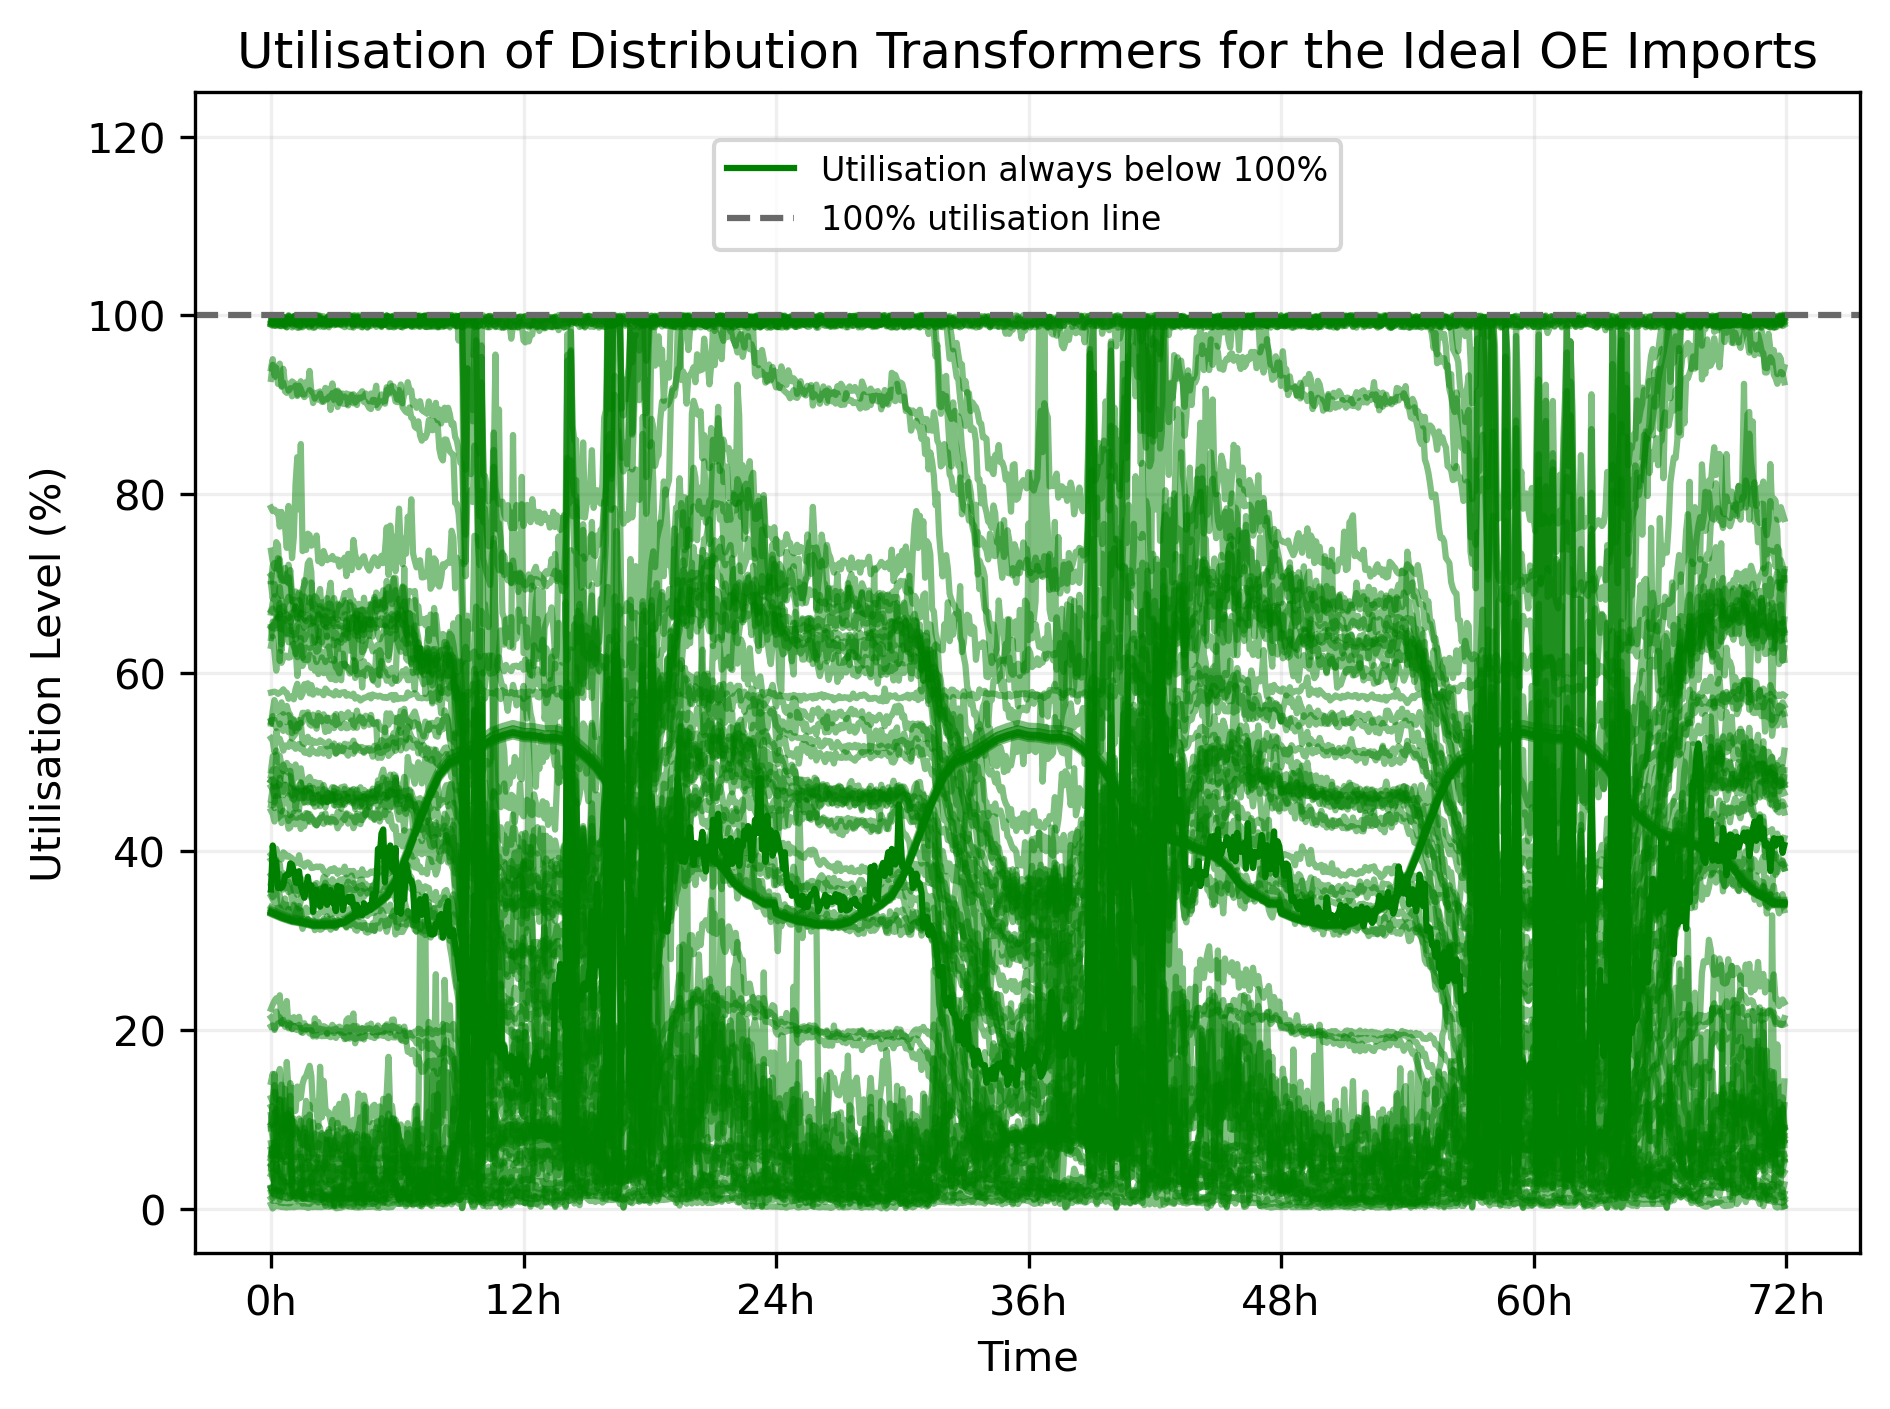

In [78]:
# Plot utilisation of all distribution transformers
x = range(num_time_steps*num_days)
y1 = save_lvtx_util
red_count = 0
yellow_count = 0
green_count = 0

plt.figure(dpi=300)
ax = plt.axes()
plt.title("Utilisation of Distribution Transformers for the Ideal OE Imports")
plt.ylabel("Utilisation Level (%)")
plt.xlabel("Time")
for itx in range(num_distr_tx):
    if (y1[itx] <= 100.49).all():
        if green_count == 0:
            plt.plot(x, y1[itx], color='green', alpha=1, label='Utilisation always below 100%') 
            green_count += 1
        else:
            plt.plot(x, y1[itx], color='green', alpha=0.5)
for itx in range(num_distr_tx):    
    if (y1[itx] > 100.49).any() and (y1[itx] <= 110.49).all():
        if yellow_count == 0:
            plt.plot(x, y1[itx], color='gold', alpha=1, label='Utilisation between 100% and 110%') 
            yellow_count += 1
        else:
            plt.plot(x, y1[itx], color='gold', alpha=0.75)
for itx in range(num_distr_tx):    
    if (y1[itx] > 110.49).any():
        if red_count == 0:
            plt.plot(x, y1[itx], color='red', alpha=1, label='Utilisation above 110%') 
            red_count =+ 1
        else:
            plt.plot(x, y1[itx], color='red', alpha=0.75)
plt.axhline(y = 100, color = 'dimgrey', linestyle = 'dashed', label='100% utilisation line')
plt.grid(alpha=0.2)
plt.ylim(-5, 125)
ax.set_xticks([0, 144, 288, 432, 576, 720, 864])
ax.set_xticklabels(['0h', '12h', '24h', '36h', '48h', '60h', '72h'])
plt.legend(loc='lower center', fontsize=8, bbox_to_anchor=(0.5, 0.85, 0, 0))
plt.tight_layout()
plt.show()

Few comments about the figure above:
- The utilisation of all distribution transformers are always within the required limits.
- The Ideal OE Imports with Integrated HV-LV Calculation was able to avoid any thermal issues with distribution transformers.

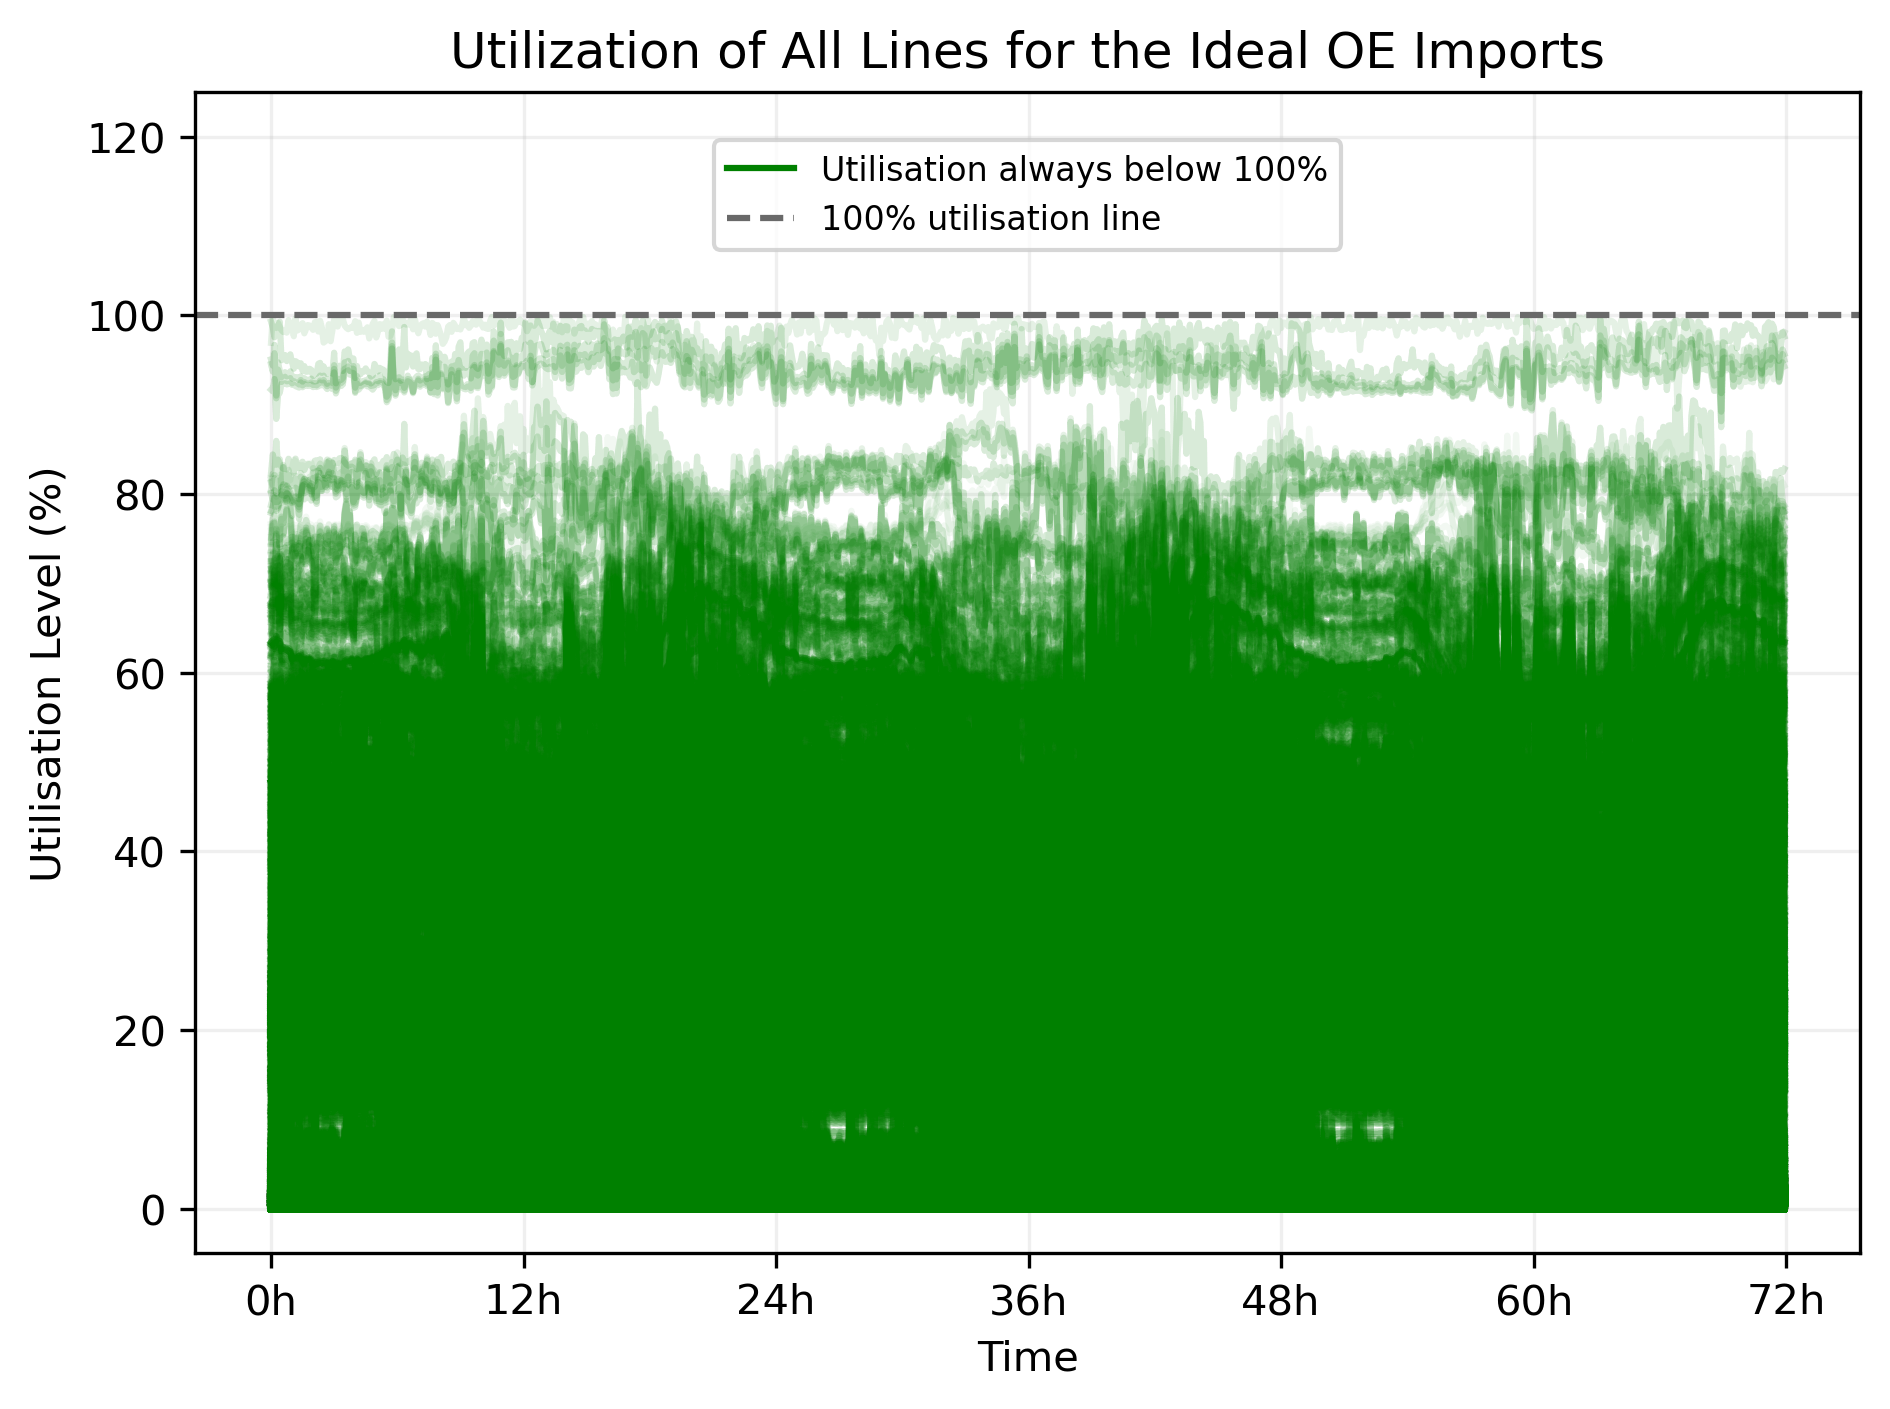

In [80]:
# Plot utilisation of all HV and LV lines
x = range(num_time_steps*num_days)
y1 = save_lines_util
green_count = 0
yellow_count = 0
red_count = 0

plt.figure(dpi=300)
ax = plt.axes()
plt.title("Utilization of All Lines for the Ideal OE Imports")
plt.ylabel("Utilisation Level (%)")
plt.xlabel("Time")
for iln in range(len(y1)):
    for iph in range(3):
        if (y1[iln, iph, :] <= 100.49).all():
            if green_count == 0:
                plt.plot(x, y1[iln, iph, :], color='green', alpha=1, label='Utilisation always below 100%') 
                green_count += 1
            else:
                plt.plot(x, y1[iln, iph, :], color='green', alpha=0.05)
for iln in range(len(y1)):    
    for iph in range(3):
        if (y1[iln, iph, :] > 100.49).any() and (y1[iln, iph, :] <= 110.49).all():
            if yellow_count == 0:
                plt.plot(x, y1[iln, iph, :], color='gold', alpha=1, label='Utilisation between 100% and 110%') 
                yellow_count += 1
            else:
                plt.plot(x, y1[iln, iph, :], color='gold', alpha=0.2)
for iln in range(len(y1)):    
    for iph in range(3):
        if (y1[iln, iph, :] > 110.49).any():
            if red_count == 0:
                plt.plot(x, y1[iln, iph, :], color='red', alpha=1, label='Utilisation above 110%') 
                red_count =+ 1
            else:
                plt.plot(x, y1[iln, iph, :], color='red', alpha=0.2)
plt.axhline(y = 100, color = 'dimgrey', linestyle = 'dashed', label='100% utilisation line')
plt.grid(alpha=0.2)
plt.ylim(-5, 125)
ax.set_xticks([0, 144, 288, 432, 576, 720, 864])
ax.set_xticklabels(['0h', '12h', '24h', '36h', '48h', '60h', '72h'])
plt.legend(loc='lower center', fontsize=8, bbox_to_anchor=(0.5, 0.85, 0, 0))
plt.tight_layout()
plt.show()

Comments about the figure above:
- The utilisation of all HV and LV lines are always within the required limits.
- The Ideal OE Imports with Integrated HV-LV Calculation was able to avoid any thermal issues on HV and LV lines.

<span style="color:red">**<u>Note</u>.</span>** These metrics can be used to do comparisons with other OE implementations, but not all metrics used in the project are calculated here. For a complete performance analysis please refer to the final report of the project.